In [1]:
#! pip install geopy

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import os
import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import f1_score, mean_absolute_percentage_error

from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              RandomForestRegressor, ExtraTreesRegressor, StackingRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostRegressor

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/home/michael/anaconda3/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
pd.set_option('display.max_columns', 50)

## Функции

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# Функция для обработки столбца 'baths'
def quantity_bath (data):
    data_output = np.zeros((len(data), 3))
    pattern = '(?:\d+(?:[.,]\d+)?|\?[.,]\d+)'
    for i in range(len(data)):
        match = re.search(pattern, str(data.iloc[i]))
        if match != None:
            var = match[0]
            var = var.replace(',', '.')
            var = float(var)
            if var % 1 == 0:
                data_output[i, 0] = var
            else:
                data_output[i, 0] = int(var)
                var_ost = var % 1
                if var_ost % 0.5 == 0:
                    data_output[i, 1] = 1
                elif var_ost - 0.5 > 0:
                    data_output[i, 1] = 1
                    data_output[i, 2] = 1
                else: data_output[i, 2] = 1
    return data_output

In [6]:
# Наличие mls_id
def have_mls(Series):
    result = np.zeros((len(Series), 1))
    for i in range(len(Series)):
        pattern = '\d+'
        match = re.search(pattern, str(Series.iloc[i]))
        if match != None:
            pattern2 = '[a-zA-Z0-9]+'
            match = re.search(pattern2, str(Series.iloc[i]))
            if match != None:
                result[i] = 1
    return result

In [7]:
# Выбор данных из столбца schools
def data_school (Series, List):
    result = np.zeros((len(Series), len(List)))
    result = pd.DataFrame(result, columns = List)
    for i in tqdm(range(len(Series))):  
        for j in range(len(List)):
            pattern = List[j]
            match = re.search(pattern, str(Series.iloc[i]))
            if match != None:
                pos = match.span()[1]
                ind  = pos
                start = 0
                end = 0 
                for k in range(len(str(Series.iloc[i]))):
                    ind += 1
                    if str(Series.iloc[i])[ind] == '[' and ind - pos < 5:
                        start = ind + 1
                    elif str(Series.iloc[i])[ind] == ']' and start != 0:
                        end = ind
                        break
                if start != 0 and end !=0 and end - start >= 1:
                    result.iloc[i, j] = str(Series.iloc[i])[start:end]
                else: result.iloc[i, j] = 'No inf'
            else: result.iloc[i, j] = 'No inf'
    return result

In [8]:
# функция выбора рейтинга и расстояния до школы
def find_number (var_list):
    result = []
    var = 0
    pattern = '(?:\d+(?:[.,]\d+)?|\?[.,]\d+)'
    for i in range(len(var_list)):
        if var_list[i].find('/') == -1:
            match = re.search(pattern, var_list[i])
            if match != None:
                var = float(match[0])
            else: var = np.NaN
        else: 
            var = var_list[i].split('/')[0]
            match = re.search(pattern, var)
            if match != None:
                var = float(match[0])
            else: var = np.NaN
        result.append(var)
    return(result)

In [9]:
# Функция для разметки типа школы
def grades_school (var):
    pattern =  '(?:-)|(?: to )|(?:–)'
    pattern_2 = '\d+'
    if len(var) != 0:
        result = np.zeros((len(var),4))
        for i in range(len(var)):
            match = re.split(pattern,  str(var[i]))
            list_range = []
            if len(match) == 2:
                for j in range(len(match)):
                    if str(match[j]).find('Preschool') != -1:
                        match[j] = 0                
                    elif str(match[j]).find('PK') != -1:
                        match[j] = 0            
                    elif str(match[j]).find('Pk') != -1:
                        match[j] = 0                     
                    elif str(match[j]).find('K') != -1:
                        match[j] = 1            
                    match_n = re.search(pattern_2, str(match[j]))
                    match[j] = int(match_n[0]) 
                for k in range(match[0], match[1]+1):
                    list_range.append(k)
                for n in list_range:
                    if n == 0:
                        result[i,0] = 1
                    elif 1 <= n <= 5:
                        result[i,1] = 1
                    elif 6 <= n <= 8:
                        result[i,2] = 1
                    elif 9 <= n <= 12:
                        result[i,3] = 1
            elif re.search(pattern_2, str(var[i])) != None:
                var_single= int(re.search(pattern_2, str(var[i]))[0])
                if var_single == 0:
                    result[i,0] = 1
                elif 1 <= var_single <= 5:
                    result[i,1] = 1
                elif 6 <= var_single <= 8:
                    result[i,2] = 1
                elif 9 <= var_single <= 12:
                    result[i,3] = 1
            else: 
                result[i,0] = 0
                result[i,1] = 0
                result[i,2] = 0
                result[i,3] = 0
        result = np.sum(result, axis = 0)
        for i in range(len(result)):
            if result[i] != 0:
                result[i] = 1
            else: result[i]= 0
    else: result = [0, 0, 0, 0]
    return result

In [10]:
def chose_distance(var, var_2):
    pattern =  '(?:-)|(?: to )|(?:–)'
    pattern_2 = '\d+'
    result_ar = np.zeros((len(var),4))
    for i in range(len(var)):
        match = re.split(pattern,  var[i])
        list_range = []
        if len(match) == 2:
            for j in range(len(match)):
                if str(match[j]).find('Preschool') != -1:
                    match[j] = 0                
                elif str(match[j]).find('PK') != -1:
                    match[j] = 0            
                elif str(match[j]).find('Pk') != -1:
                    match[j] = 0                     
                elif str(match[j]).find('K') != -1:
                    match[j] = 1            
                match_n = re.search(pattern_2, str(match[j]))
                match[j] = int(match_n[0]) 
            for k in range(match[0], match[1]+1):
                list_range.append(k)
            for n in list_range:
                if n == 0:
                    result_ar[i,0] = var_2[i]
                elif 1 <= n <= 5:
                    result_ar[i,1] = var_2[i]
                elif 6 <= n <= 8:
                    result_ar[i,2] = var_2[i]
                elif 9 <= n <= 12:
                    result_ar[i,3] = var_2[i]
        elif re.search(pattern_2, var[i]) != None:
            var_single= int(re.search(pattern_2, var[i])[0])
            if var_single == 0:
                result_ar[i,0] = var_2[i]
            elif 1 <= var_single <= 5:
                result_ar[i,1] = var_2[i]
            elif 6 <= var_single <= 8:
                result_ar[i,2] = var_2[i]
            elif 9 <= var_single <= 12:
                result_ar[i,3] = var_2[i]
        else: 
            result_ar[i,0] = 0
            result_ar[i,1] = 0
            result_ar[i,2] = 0
            result_ar[i,3] = 0
    result = result_ar[0]
    for i in range(1, len(result_ar)):
        for j in range(len(result)):
            if result_ar[i, j] < result[j] and result_ar[i, j] != 0 and result[j] != 0:
                result[j] = result_ar[i, j]
            elif result_ar[i, j] != 0 and result[j] == 0:
                result[j] = result_ar[i, j]
    return result


In [11]:
# Функция для определения минимального расстояния до школ
def grades_school_distance (var, var_2):
    #pattern =  '(?:-)|(?: to )|(?:–)'
    #pattern_2 = '\d+'
    var_1_new = []
    var_2_new = []
    if len(var) != 0 and len(var) != 0: 
        if len(var) == len(var_2):
            result = chose_distance(var, var_2)               
        elif len(var) > len(var_2):
            for i in range(len(var_2)):
                var_1_new.append(var[i])
            result = chose_distance(var_1_new, var_2)
        elif len(var) < len(var_2):
            for i in range(len(var)):
                var_2_new.append(var_2[i])
            result = chose_distance(var, var_2_new)
    else: result = [0, 0, 0, 0]
    return result

In [12]:
# функция для получеyия DataFrame с рангами школ
def school_grades_data (Series):
    school_rating = pd.DataFrame(np.zeros((len(Series), 4)))
    for i in range(len(Series)):
        grades = grades_school(Series[i])
        school_rating.loc[i, 0] = grades[0]
        school_rating.loc[i, 1] = grades[1]
        school_rating.loc[i, 2] = grades[2]
        school_rating.loc[i, 3] = grades[3]
    return school_rating 

In [13]:
# функция для получения DataFrame с min растояниями до школ по рангам
def school_gr_distance (Series, Series_2):
    school_distance = pd.DataFrame(np.zeros((len(Series), 4)))
    for i in tqdm(range(len(Series))):
        distance = grades_school_distance(Series.iloc[i], Series_2.iloc[i])
        school_distance.loc[i, 0] =distance[0]
        school_distance.loc[i, 1] =distance[1]
        school_distance.loc[i, 2] =distance[2]
        school_distance.loc[i, 3] =distance[3]
    return school_distance

In [14]:
def find_name_school(list_sc):
    result = []
    stop_words = ['SCHOOL', 'ELEMENTARY', 'MIDDLE', 'HIGH']
    chars = ['[\]']
    if type(list_sc) == list:
        pattern = "\w+"
        for text in list_sc:
            words = ''
            for i in text: #удаляем знаки
                if i in chars:
                    words += ''.join(' ')
                else: words += ''.join(i)
            name_school =[]
            match = re.findall(pattern,words)
            for j in match:
                j = j.upper()
                if j not in stop_words and len(j) > 2:
                    name_school.append(j)
            result.append(name_school)
    else: result = 0
    return result

In [15]:
def type_school(Series_school, City_school, Public_school, Private_school):
    series_type_school = pd.Series()
    for i in tqdm(range(len(Series_school))):
        list_school = find_name_school(Series_school.iloc[i])
        if list_school != 0 and len(list_school) != 0:
            type_school = []
            #print(list_school)
            public = Public_school[Public_school['CITY'] == City_school[i].upper()]['NAME']
            private = Private_school[Private_school['CITY'] == City_school[i].upper()]['NAME']
            for list_word in list_school:    
                #print(list_word)
                criteria_public = 0
                criteria_private = 0
                #public = Series_public[Series_public.str.contains(list_word[0]) == True]
                #private = Series_private[Series_private.str.contains(list_word[0]) == True]
                for j in list_word:
                    if len(public[public.str.contains(j)]) != 0:
                        criteria_public +=1
                    if len(private[private.str.contains(j)]) != 0:
                        criteria_private += 1
                if 'PRIVATE' in list_word:
                    type_school.append(2)
                elif criteria_public == len(list_word):
                    type_school.append(1)
                elif criteria_private == len(list_word):
                    type_school.append(2)              
                elif criteria_private == criteria_public and criteria_private > 0:
                    type_school.append(2)
                else: type_school.append(0)
            #print(type_school)
            series_type_school.loc[i] = type_school
        else: series_type_school.loc[i] = 0
    return series_type_school

In [16]:
# Функция для заполнения NaN по совпадающим MlsId
def mlsid_analysis (data_base, name_column, mlsid_base):
    result = data_base[name_column].copy()
    index_nan = data_base[data_base[name_column].isna() == True].index
    for index in tqdm(index_nan):
        mlsid_finde = data_base.loc[index, 'MlsId']
        city_finde = data_base.loc[index, 'city']
        if mlsid_finde in mlsid_base:
            var = data_base[(data_base['MlsId'] == mlsid_finde) & (data_base['city'] == city_finde)][name_column].mode()
            if len(var) == 0:
                result[index] = np.NaN
            elif len(var) >= 2:
                result[index] = var[0]
            else: result[index] = var
    return result           

In [17]:
# Функция для заполнения переменных по совпадающим MlsId
def mlsid_analysis_2 (data_base, name_column, mlsid_base):
    result = data_base[name_column].copy()
    for mlsid in tqdm(mlsid_base):
        city_list = data_base[data_base['MlsId'] == mlsid]['city'].unique()
        for city in city_list:
            var = data_base[(data_base['MlsId'] == mlsid) & (data_base['city'] == city)][name_column].mode()
            index = data_base[(data_base['MlsId'] == mlsid) & (data_base['city'] == city)].index
            result.loc[index, name_column] = var
    return result

In [18]:
# Функция для поиска текстовой информации в столбце homeFacts
def find_text_info (var):
    result = ''
    pattern = '(?:(\w+ )+\w+\W\w+)|(?:(\w+ )+\w+)'
    match = re.search(pattern,var)
    if match != None:
        result = match[0]
    else: result = np.NaN
    return result

In [19]:
#функция поиска числовой информации из строки
def find_number_info (var):
    result = 0
    pattern = '(?:\d+(?:[.,]\d+)?|\?[.,]\d+)'
    match = re.search(pattern, var)
    if match != None:
        match = match[0].replace(',','.')
        result = float(match)
    else: result = np.NaN
    return result

In [20]:
# Построение графиков Boxplot
def get_boxplot(data):
    columns = data.columns
    line = min(3, len(columns))
    rows = (len(columns) - 1) // line + 1
    fig = plt.figure(figsize = (line * 6, rows * 4))
    for i in range(len(columns)):
        j = columns[i]
        for_plot = data[j].value_counts()
        ax = fig.add_subplot(rows, line, i + 1)
        ax.boxplot(x=data[j], data=data[data[j].isin(for_plot)], vert = False)
        ax.set_title('Boxplot for ' + j)
    plt.show()

In [21]:
#Построение гистограмм
def visualize_distributions(data):
  columns = data.columns
  line = min(3, len(columns))
  rows = (len(columns) - 1) // line + 1
  fig = plt.figure(figsize = (line * 6, rows * 4))
  for i in range(len(columns)):
    j = columns[i]
    hist, bins = np.histogram(data[j], bins = 20)
    ax = fig.add_subplot(rows, line, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(j)
  plt.show()

In [22]:
# Функция для выбора популярных значений категориальных признаков
def top_variable (Series, percent):
    list_variable = Series.value_counts()
    top_variable = int(np.percentile(list_variable, percent))
    list_top_variable = list_variable[list_variable > top_variable]
    result = []
    for i in Series:
        if i in list_top_variable:
            result.append(i)
        else: result.append('other')
    return result

In [23]:
# Функция для присвоения класса по количеству спален
def quantity_beds(var):
    result = 0
    if 0 < var < 3:
        result = 1
    elif var == 3:
        result = 2
    elif 3 < var <= 5:
        result = 3
    elif 5 < var <= 10:
        result = 4
    elif 10 < var:
        result = 5
    else: result = 0
    return result

In [1]:
DATA_PATH = 'https://drive.google.com/drive/folders/1X6x9QOJH5gx2ZCQtSVhwXz8Fi_Gy2hN1?usp=sharing' #'../data/'

In [8]:
RANDOM_SEED = 42

In [26]:
name_grades = ['preschool','elementary_school','middle_school','high_school']

In [27]:
os.listdir(DATA_PATH)

['df_home_info.csv',
 'df_school_base.csv',
 'df_quantity_variable_2.csv',
 'Public_Schools.csv',
 'df_private_school.csv',
 'data.csv',
 'Private_Schools.csv',
 'type_school_info.csv',
 'us-cities-demographics.csv',
 'best_model.hdf5',
 'df_quantity_variable.csv',
 'df_public_school.csv',
 'df_type_school.csv',
 'all_us_zipcodes.csv',
 'link']

In [28]:
df = pd.read_csv(DATA_PATH + 'data.csv')

In [29]:
df_work = df.copy()

In [30]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [31]:
display(df_work)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


In [32]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [33]:
df_work['status'].value_counts()

for sale                156104
Active                  105207
For sale                 43465
foreclosure               6426
New construction          5475
                         ...  
Coming soon: Nov 12.         1
Sold: $285,000               1
Conditional Contract         1
Reactivated                  1
Coming soon: Dec 1.          1
Name: status, Length: 159, dtype: int64

In [34]:
df_work['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [35]:
df_work['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

In [36]:
df_work['mls-id'].value_counts()

No MLS#      3
No           3
74184012     2
19-3389      2
201909859    2
            ..
944450       1
957238       1
219073301    1
313097       1
219044064    1
Name: mls-id, Length: 24907, dtype: int64

In [37]:
df_work['MlsId'].value_counts()

NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
No                          9
                           ..
40890635                    1
219083696                   1
C7422757                    1
21559032                    1
U8067478                    1
Name: MlsId, Length: 232944, dtype: int64

In [38]:
df_work.loc[8, 'schools'][0]

'['

In [39]:
df_work.loc[8, 'homeFacts']

"{'atAGlanceFacts': [{'factValue': '1970', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '124582', 'factLabel': 'lotsize'}, {'factValue': '$68', 'factLabel': 'Price/sqft'}]}"

## Exploration Data Analysis

### Столбец city и zipcode

In [40]:
dict_city_zip = df_work['zipcode'].unique()
for i in dict_city_zip:
    city_name = df_work[df_work['zipcode'] == i]['city'].value_counts().index[0]
    index_city = df_work[df_work['zipcode'] == i].index
    df_work.loc[index_city, 'city'] = city_name
    

In [41]:
df_work['city'].value_counts()

Houston         24575
San Antonio     16171
Miami           15511
Jacksonville     9887
Dallas           8978
                ...  
Fort Myers          1
Sugar Land          1
China Spring        1
Garrett             1
Piney Flats         1
Name: city, Length: 1330, dtype: int64

In [42]:
df_work['state'].value_counts()

FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
OS         1
BA         1
Fl         1
OT         1
AL         1
Name: state, dtype: int64

In [43]:
df_city_demograph = pd.read_csv(DATA_PATH + 'us-cities-demographics.csv', sep = ';')

In [44]:
df_city_demograph

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
1,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
2,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
3,Hampton,Virginia,35.5,66214.0,70240.0,136454,19638.0,6204.0,2.48,VA,Black or African-American,70303
4,Lakewood,Colorado,37.7,76013.0,76576.0,152589,9988.0,14169.0,2.29,CO,Hispanic or Latino,33630
...,...,...,...,...,...,...,...,...,...,...,...,...
2886,Boca Raton,Florida,47.3,44760.0,48466.0,93226,4367.0,21117.0,2.22,FL,Hispanic or Latino,14735
2887,Fort Lauderdale,Florida,42.8,93948.0,84639.0,178587,8897.0,47582.0,2.38,FL,Hispanic or Latino,28148
2888,Oxnard,California,31.0,101906.0,105346.0,207252,6367.0,78678.0,4.08,CA,White,165423
2889,Somerville,Massachusetts,31.0,41028.0,39306.0,80334,2103.0,22292.0,2.43,MA,White,62927


In [45]:
df_city_demograph[df_city_demograph['City'] == 'Peoria']['Total Population']#.mean()

1       118661
563     118661
620     171242
712     118661
1027    171242
1635    171242
2369    118661
2750    171242
2753    171242
2756    118661
Name: Total Population, dtype: int64

In [46]:
df_city_demograph.loc[1027,:]

City                       Peoria
State                     Arizona
Median Age                   36.9
Male Population             80139
Female Population           91103
Total Population           171242
Number of Veterans          13019
Foreign-born                14260
Average Household Size       2.97
State Code                     AZ
Race                        Asian
Count                        6631
Name: 1027, dtype: object

In [47]:
df_city_demograph[df_city_demograph['City'].str.find('outher') == True] #== df_work.loc[0, 'city']]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count


In [48]:
city_unique = df_work['city'].unique()
dict_city = dict()
for i in city_unique:
    state_name = df_work[df_work['city'] == i]['state'].unique()
    dict_city[i] = list(state_name)

In [49]:
#dict_city

In [50]:
df_work[df_work['city'] == 'Other City Value - Out Of Area']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
85581,Active,NaN,"Detached, Two Story",6789 White River Home,NaN,"{'atAGlanceFacts': [{'factValue': '1989', 'fac...",NaN,Other City Value - Out Of Area,"[{'rating': [], 'data': {'Distance': [], 'Grad...","4,000",123456,NaN,NY,NaN,NaN,NaN,A10764075,"899,999"
332895,Active,NaN,NaN,1001 Panama,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Other City Value - Out Of Area,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,5940,NaN,FL,NaN,NaN,NaN,H837984,"125,000"


In [51]:
zip_code = pd.read_csv(DATA_PATH + 'all_us_zipcodes.csv')

In [52]:
zip_code

,code,city,state,county,area_code,lat,lon
0,501,Holtsville,NY,SUFFOLK,NaN,40.922326,-72.637078
1,544,Holtsville,NY,SUFFOLK,NaN,40.922326,-72.637078
2,1001,Agawam,MA,HAMPDEN,NaN,42.140549,-72.788661
3,1002,Amherst,MA,HAMPSHIRE,NaN,42.367092,-72.464571
4,1003,Amherst,MA,HAMPSHIRE,NaN,42.369562,-72.635990
...,...,...,...,...,...,...,...
42361,99926,Metlakatla,AK,PRINCE WALES KETCHIKAN,NaN,55.094325,-131.566827
42362,99927,Point Baker,AK,PRINCE WALES KETCHIKAN,NaN,55.517921,-132.003244
42363,99928,Ward Cove,AK,KETCHIKAN GATEWAY,NaN,55.395359,-131.675370
42364,99929,Wrangell,AK,WRANGELL PETERSBURG,NaN,56.449893,-132.364407


In [53]:
len(df_city_demograph[(df_city_demograph['City'] == 'Spokane Valley') & (df_city_demograph['State Code'] == 'WA')]['Total Population'].mode())

1

In [54]:
df_city_demograph[df_city_demograph['City'] == 'Southern Pines']

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count


In [55]:
dict_city['Southern Pines']

['NC']

In [56]:
type_city_pop = pd.Series(data = np.zeros(len(df_work)))
for i in tqdm(dict_city.keys()):
    for j in dict_city[i]:
        index = df_work[(df_work['city'] == i) & (df_work['state'] == j)].index
        var = df_city_demograph[(df_city_demograph['City'] == i) & (df_city_demograph['State Code'] == j)]['Total Population'].mode()
        if len(list(var)) > 1:
            population = var[0]
        elif len(var) == 0:
            population = 0
        else: population = var
        if 1 <= float(population) <= 100000:
            type_city_pop[index] = 1
        elif 100000 < float(population) <= 300000:
            type_city_pop[index] = 2
        elif 300000 < float(population) <= 1000000:
            type_city_pop[index] = 3
        elif 1000000 < float(population):
            type_city_pop[index] = 4

100%|██████████| 1330/1330 [01:23<00:00, 15.98it/s]


In [57]:
type_city_pop

0         0.0
1         1.0
2         4.0
3         4.0
4         2.0
         ... 
377180    0.0
377181    4.0
377182    0.0
377183    4.0
377184    4.0
Length: 377185, dtype: float64

<AxesSubplot:>

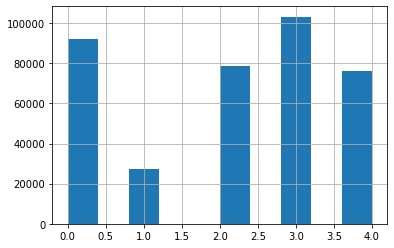

In [58]:
type_city_pop.hist() # большое кол-во городов осталось без разметки

In [59]:
index_no_type_p = type_city_pop[type_city_pop == 0].index
df_work.loc[index_no_type_p, ['city', 'state']].head(50)

,city,state
0,Southern Pines,NC
8,Mason City,IA
10,Flushing,NY
15,Brooklyn,NY
18,Tomball,TX
23,Spring,TX
29,Brooklyn,NY
33,Sunny Isles Beach,FL
40,Rotonda West,FL
45,Sylmar,CA


In [60]:
df_city_demograph[df_city_demograph['City'].str.find('thens') == True]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
159,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,White,79931
252,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,Hispanic or Latino,13159
814,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,Black or African-American,34583
1435,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,Asian,6635
2564,Athens-Clarke County unified government,Georgia,26.5,57415.0,65148.0,122563,3953.0,12868.0,2.44,GA,American Indian and Alaska Native,593


In [61]:
# Проверим неразмеченные данные без учета штата, и без первой буквы в названии города
for i in tqdm(index_no_type_p):
    name_city = df_work.loc[i, ['city']]
    var = df_city_demograph[df_city_demograph['City'].str.find(name_city[0][1:]) == True]['Female Population'].mode()
    if len(var) > 1:
        population = var[0]
    elif len(var) == 0:
        population = 0
    else: population = var
    if 1 <= float(population) <= 100000:
        type_city_pop[i] = 1
    elif 100000 < float(population) <= 300000:
        type_city_pop[i] = 2
    elif 300000 < float(population) <= 1000000:
        type_city_pop[i] = 3
    elif 1000000 < float(population):
        type_city_pop[i] = 4

100%|██████████| 92163/92163 [05:39<00:00, 271.32it/s]


<AxesSubplot:>

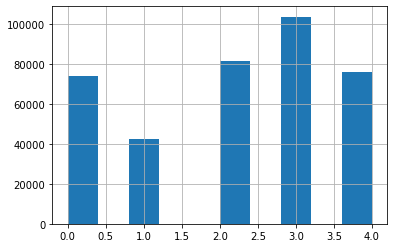

In [62]:
type_city_pop.hist()

In [63]:
df_work.loc[type_city_pop[type_city_pop == 0].index, :]['state'].unique()

array(['NC', 'IA', 'NY', 'TX', 'FL', 'CA', 'TN', 'WA', 'GA', 'OH', 'PA',
       'AZ', 'MD', 'VT', 'CO', 'MI', 'OR', 'UT', 'KY', 'IL', 'NJ', 'ME',
       'MA', 'VA', 'WI', 'IN', 'NV', 'SC', 'DE', 'Fl', 'AL', 'OS', 'MO'],
      dtype=object)

In [64]:
#Заполнить не размеченные данные, по наиболее часто встречающейся разметки для штата
index_state_find = type_city_pop[type_city_pop == 0].index
for i in index_state_find:
    state_find = df_work.loc[i, 'state']
    index_find_state = df_work[df_work['state'] == state_find].index
    type_city_pop[i] = type_city_pop[index_find_state].mode()

<AxesSubplot:>

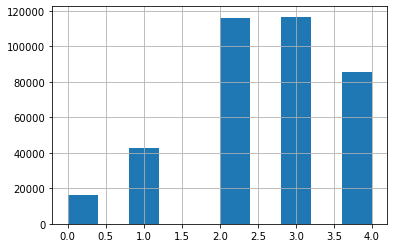

In [65]:
type_city_pop.hist()

In [66]:
#Заполнить не размеченные данные, по среднему количеству жителей в городах в зависимости от штата
index_state_find_2 = type_city_pop[type_city_pop == 0].index
for i in index_state_find_2:
    state_find = df_work.loc[i, 'state']
    population = df_city_demograph[df_city_demograph['State Code'] == state_find]['Total Population'].mean()
    if 1 <= float(population) <= 100000:
        type_city_pop[i] = 1
    elif 100000 < float(population) <= 300000:
        type_city_pop[i] = 2
    elif 300000 < float(population) <= 1000000:
        type_city_pop[i] = 3
    elif 1000000 < float(population):
        type_city_pop[i] = 4

<AxesSubplot:>

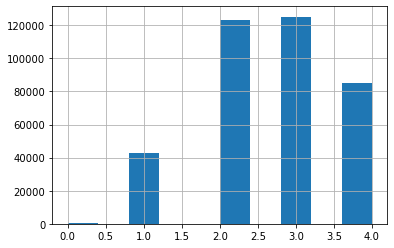

In [67]:
type_city_pop.hist()

In [68]:
df_work.loc[type_city_pop[type_city_pop == 0].index, 'state'].unique()

array(['VT', 'Fl', 'OS'], dtype=object)

In [69]:
df_work[df_work['state'] == 'Fl']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
113694,Active,NaN,NaN,9543 W Mcnab #201,NaN,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Tamarac,"[{'rating': ['7', '5', '5'], 'data': {'Distanc...","1,140",33321,NaN,Fl,NaN,NaN,NaN,F10197956,"174,000"


In [70]:
type_city_pop[df_work[df_work['city'] == 'Tamarac'].index].unique()

array([2., 0.])

In [71]:
type_city_pop[df_work[df_work['state'] == 'Fl'].index] = type_city_pop[df_work[df_work['city'] == 'Tamarac'].index].mode()

In [72]:
df_work[df_work['state'] == 'OS']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
308229,Active,NaN,NaN,435 pescador,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,100",00000,NaN,OS,NaN,NaN,NaN,CV18033361,"125,000"


In [73]:
df_work[df_work['city'] == 'Foreign Country']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
308229,Active,NaN,NaN,435 pescador,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,100",00000,NaN,OS,NaN,NaN,NaN,CV18033361,"125,000"


In [74]:
# оставшиеся данные запищем в класс 1 (общее население штата VT 626 тыс)
type_city_pop[type_city_pop[type_city_pop == 0].index] = 1

<AxesSubplot:>

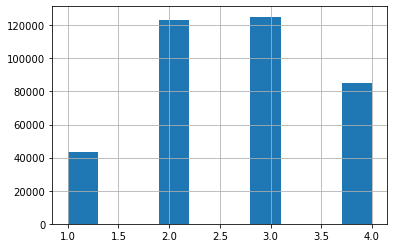

In [75]:
type_city_pop.hist()

In [76]:
# для использовании в обучении переведем данные в формат dummies переменной
city_pop = pd.get_dummies(type_city_pop)

In [77]:
city_pop #качественный тип переменных

,1.0,2.0,3.0,4.0
0,0,0,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,1,0,0
...,...,...,...,...
377180,0,1,0,0
377181,0,0,0,1
377182,0,0,1,0
377183,0,0,0,1


### Столбцы 'mls-id' и 'MlsId'

In [78]:
df_work[['mls-id', 'MlsId']]

,mls-id,MlsId
0,NaN,611019
1,NaN,201916904
2,NaN,FR19221027
3,NaN,14191809
4,NaN,861745
...,...,...
377180,NaN,A10702700
377181,NaN,10374233
377182,NaN,NaN
377183,NaN,NaN


In [79]:
# Проверка на совместное наличие значений в столбцах 'mls-id', 'MlsId'
df_work[pd.notnull(df_work['mls-id'])]['MlsId'].count()

0

In [80]:
index = df_work[df_work['MlsId'].isna() == True].index
df_work.loc[index, 'MlsId'] = df_work.loc[index, 'mls-id']

In [81]:
df_work['MlsId'].count()

335247

In [82]:
df['MlsId'].count()

310305

In [83]:
df_work['mls-id'].count()

24942

In [84]:
df['MlsId'].count() + df_work['mls-id'].count()

335247

In [85]:
df_work = df_work.drop('mls-id', axis = 1)

In [86]:
df_work['MlsId'] = df_work['MlsId'].apply(lambda x: np.NaN if x in ['NO MLS', 'No MLS #', 'No', 'No mls', 'No ', 'No MLS', 'NOMLSID'] else x)

In [87]:
df_work['MlsId'] = df_work['MlsId'].apply(lambda x: np.NaN if re.search('\w[,][ ]\w', str(x)) != None else x)

In [88]:
mlsid_count = df_work['MlsId'].value_counts()
mlsid_count

1412350       6
2101941       6
2088662       6
14216924      5
DCDC449148    5
             ..
2107813       1
2091305       1
10594657      1
7515689       1
U8067478      1
Name: MlsId, Length: 245160, dtype: int64

In [89]:
mlsid_count.index[0]

'1412350'

In [90]:
unique_mlsid = [] # список, содержащий уникальные mls id, встречающихся в df_work 2 и более раз
for i in range(len(mlsid_count)):
    if mlsid_count[i] > 1:
        unique_mlsid.append(mlsid_count.index[i])

In [91]:
df_work[df_work['MlsId'] == '2101941']['city'].unique()[0]

'Nashville'

In [92]:
df_work['mls_id'] = have_mls(df_work['MlsId'])

In [93]:
df_work[['MlsId', 'mls_id']]

,MlsId,mls_id
0,611019,1.0
1,201916904,1.0
2,FR19221027,1.0
3,14191809,1.0
4,861745,1.0
...,...,...
377180,A10702700,1.0
377181,10374233,1.0
377182,NaN,0.0
377183,NaN,0.0


Cтолбец mls_id из df_work используетсяпри обучении модели

### Столбец status

In [94]:
df_work['status'] = df_work['status'].apply(lambda x: 'active' if re.search('ctiv', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'for sale' if re.search('or sal', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'foreclosure' if re.search('oreclos', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'pending' if re.search('ending', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'pending' if x in ['P'] else x)
df_work['status'] = df_work['status'].apply(lambda x: 'auction' if re.search('uctio', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'for rent' if re.search('rent', str(x)) != None else x)
df_work['status'] = df_work['status'].apply(lambda x: 'under contract show' if x in ['Under Contract Show', 'Under Contract   Showing', 'Under Contract', ] else x)
df_work['status'] = df_work['status'].apply(lambda x: 'coming soon' if re.search('oming soon', str(x)) != None else x)

In [95]:
status_count = df_work['status'].value_counts()
status_count.head(50)

for sale                             199569
active                               106558
foreclosure                           10909
auction                                6947
pending                                6852
under contract show                    2666
New                                     690
Contingent                              581
Price Change                            563
for rent                                412
recently sold                           287
Under Contract Backups                  252
Contingent Finance And Inspection       240
coming soon                             110
Back on Market                          106
Contingent Show                         101
Option Contract                          54
C                                        39
Pi                                       36
Contract P                               36
Listing Extended                         28
Due Diligence Period                     27
Contract Contingent On Buyer Sal

In [96]:
top_status_freqs = list(df_work['status'].value_counts())

In [97]:
top_status = int(np.percentile(top_status_freqs, 90))
top_status_list = []
for i in range(len(status_count)):
    if status_count[i] >= top_status:
        top_status_list.append(status_count.index[i])
top_status_list

['for sale',
 'active',
 'foreclosure',
 'auction',
 'pending',
 'under contract show']

In [98]:
df_work['status'] = df_work['status'].apply(lambda x: 'other' if x not in top_status_list else x)

In [99]:
df_work['status'].value_counts()

for sale               199569
active                 106558
other                   43684
foreclosure             10909
auction                  6947
pending                  6852
under contract show      2666
Name: status, dtype: int64

In [100]:
df_status = pd.get_dummies(df_work['status'])
df_status

,active,auction,for sale,foreclosure,other,pending,under contract show
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
377180,0,0,0,0,1,0,0
377181,0,0,1,0,0,0,0
377182,0,0,1,0,0,0,0
377183,0,0,0,0,1,0,0


Используем для обучения модели

### Столбец propertyType

In [101]:
df_work['propertyType'].value_counts().head(50)

single-family home                  92206
Single Family                       62869
Single Family Home                  31728
condo                               25968
lot/land                            20552
Condo                               16561
townhouse                           11464
Land                                10934
multi-family                         7900
Condo/Townhome/Row Home/Co-Op        7701
Townhouse                            6936
Traditional                          5913
coop                                 3266
Multi Family                         2794
High Rise                            1823
Ranch                                1781
mobile/manufactured                  1618
Detached, One Story                  1614
Single Detached, Traditional         1581
Contemporary                         1557
Multi-Family Home                    1501
1 Story                              1234
Colonial                             1205
Mobile / Manufactured             

In [102]:
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'single family home' if x in ['single-family home', 'Single Family', 'Single Family Home', 'SingleFamilyResidence'] else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'condo' if re.search('ondo', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'land' if re.search('and', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'townhouse' if re.search('ownhous', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'multi-family' if re.search('ulti', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'mobile/manufactured' if re.search('anufacture', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'ranch' if re.search('anch', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'traditional' if re.search('aditiona', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'cooperative' if re.search('oop', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'contemporary' if re.search('ontempora', str(x)) != None else x)
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'detached' if re.search('etache', str(x)) != None else x)

In [103]:
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'detached' if re.search('tor', str(x)) != None else x)

In [104]:
df_work['propertyType'] = df_work['propertyType'].apply(lambda x: 'mobile/manufactured' if re.search('obile', str(x)) != None else x)

In [105]:
df_work['propertyType'] = top_variable (df_work['propertyType'], 98)

In [106]:
df_work['propertyType'].value_counts()

single family home    187023
other                  55477
condo                  51481
land                   31501
townhouse              18572
multi-family           12513
traditional             9080
detached                7737
cooperative             3801
Name: propertyType, dtype: int64

In [107]:
#Переведем Series df_work['propertyType'] в dummies переменную
df_property_type = pd.get_dummies(df_work['propertyType'])
display(df_property_type)

,condo,cooperative,detached,land,multi-family,other,single family home,townhouse,traditional
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
377180,0,0,0,0,0,0,1,0,0
377181,1,0,0,0,0,0,0,0,0
377182,0,0,0,0,0,0,1,0,0
377183,0,0,0,0,0,1,0,0,0


df_property_type используется при дальнейшем обучении

### Столбцы street и city
В столбце street 377183 из 377185 значений 

In [108]:
df_work['street'] = df_work['street'].fillna('Unknown Address')

In [109]:
df_work['street'] = df_work['street'].apply(lambda x: 'Unknown Address' if x in ['Address Not Disclosed', 'Undisclosed Address', '(undisclosed Address)', 'Address Not Available'] else x)

In [110]:
df_work['street'].value_counts().head()

Unknown Address         1829
2103 E State Hwy 21       57
11305 Gulf Fwy            54
17030 Youngblood Rd.      38
NE 58th Cir               34
Name: street, dtype: int64

In [111]:
len(df_work[df_work['street'] == 'Unknown Address']['city'].unique())

161

1829 неизвестных адресов не указано в 161 городе 

In [112]:
df_work[(df_work['city'] == df_work[df_work['street'] == 'Unknown Address']['city'].unique()[1]) & (df_work['zipcode'] == '11219')]['street'].value_counts()

970 41st St                2
6310 12th Ave              1
1323-1325 66 St            1
1328 62nd St               1
912 49th St                1
                          ..
6819 Ft. Hamilton Pkwy     1
930 52nd St                1
1310 62nd St               1
1257 Bay Ridge Ave         1
1330 62 St                 1
Name: street, Length: 107, dtype: int64

Информация в дальнейшем обучении не используется

### Столбец 'baths'

In [113]:
df_work['baths'].value_counts()

2 Baths           52466
3 Baths           35506
2                 20452
2.0               16576
4 Baths           14764
                  ...  
1 / 1 / 1 / 1         1
41.0                  1
4.75 Baths            1
64.0                  1
Bathrooms: 241        1
Name: baths, Length: 229, dtype: int64

In [114]:
df_work['baths'] = df_work['baths'].apply(lambda x: find_number_info(str(x)))

In [115]:
df_work['baths'].count()

269347

In [116]:
df_work['baths']  = mlsid_analysis (df_work, 'baths', unique_mlsid)

100%|██████████| 107838/107838 [50:50<00:00, 35.35it/s] 


In [117]:
df_work['baths'].count()

303623

In [118]:
df_work['baths'].max()

750.0

In [119]:
df_work[df_work['baths'] == df_work['baths'].max()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,MlsId,target,mls_id
1109,active,NaN,traditional,3624 Douglas Ave,750.0,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",1,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...","1,758",75219,Baths,TX,NaN,NaN,14240509,"499,000",1.0
2022,active,NaN,other,920 I St NW #411,750.0,"{'atAGlanceFacts': [{'factValue': '2013', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '8'], 'data': {'Di...","1,367",20001,NaN,DC,NaN,NaN,DCDC449992,"1,499,000",1.0
3594,active,NaN,other,601 W 11th Ave #409,750.0,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,Denver,"[{'rating': ['5', 'NR', '5', '2'], 'data': {'D...",873,80204,Baths,CO,NaN,NaN,7106586,"348,900",1.0
7564,active,NaN,other,1260 Xavier St,750.0,"{'atAGlanceFacts': [{'factValue': '1936', 'fac...",NaN,Denver,"[{'rating': ['2', '2', '2'], 'data': {'Distanc...","1,864",80204,Baths,CO,NaN,NaN,5419627,"560,000",1.0
7693,active,NaN,condo,3314 Douglas Ave Unit 202D,750.0,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",3,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","1,336",75219,Baths,TX,3,NaN,14237911,"285,000",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372603,active,NaN,other,601 Pennsylvania Ave NW #212,750.0,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '5'], 'data': {'Di...",801,20004,NaN,DC,NaN,NaN,DCDC444552,"449,000",1.0
375634,active,NaN,condo,3225 Turtle Creek Blvd #1646,750.0,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",832,75219,Baths,TX,NaN,NaN,14215205,"219,500",1.0
376012,active,NaN,condo,2262 Alterbrook Ln,750.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","2,102",75219,Baths,TX,NaN,NaN,14204976,"464,900",1.0
376147,active,NaN,condo,3225 Turtle Creek Blvd #528,750.0,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",837,75219,Baths,TX,22,NaN,14222399,"240,000",1.0


In [120]:
df[df['baths'].str.find('50') == True] #Исходные данные

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
1109,Active,NaN,"Attached or 1/2 Duplex, Traditional",3624 Douglas Ave,750,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",1,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...","1,758",75219,Baths,TX,NaN,NaN,NaN,14240509,"499,000"
2022,Active,NaN,NaN,920 I St NW #411,750,"{'atAGlanceFacts': [{'factValue': '2013', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '8'], 'data': {'Di...","1,367",20001,NaN,DC,NaN,NaN,NaN,DCDC449992,"1,499,000"
3594,Active,NaN,NaN,601 W 11th Ave #409,750,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,DENVER,"[{'rating': ['5', 'NR', '5', '2'], 'data': {'D...",873,80204,Baths,CO,NaN,NaN,NaN,7106586,"348,900"
7564,Active,NaN,NaN,1260 Xavier St,750,"{'atAGlanceFacts': [{'factValue': '1936', 'fac...",NaN,DENVER,"[{'rating': ['2', '2', '2'], 'data': {'Distanc...","1,864",80204,Baths,CO,NaN,NaN,NaN,5419627,"560,000"
7693,Active,NaN,Condo/Townhome,3314 Douglas Ave Unit 202D,750,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",3,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","1,336",75219,Baths,TX,3,NaN,NaN,14237911,"285,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372603,Active,NaN,NaN,601 Pennsylvania Ave NW #212,750,"{'atAGlanceFacts': [{'factValue': '1991', 'fac...",NaN,Washington,"[{'rating': ['8', '8', '3', '5'], 'data': {'Di...",801,20004,NaN,DC,NaN,NaN,NaN,DCDC444552,"449,000"
375634,Active,NaN,"Condo/Townhome, Contemporary/Modern",3225 Turtle Creek Blvd #1646,750,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",832,75219,Baths,TX,NaN,NaN,NaN,14215205,"219,500"
376012,Active,NaN,"Condo/Townhome, Other (See Remarks)",2262 Alterbrook Ln,750,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","2,102",75219,Baths,TX,NaN,NaN,NaN,14204976,"464,900"
376147,Active,NaN,"Condo/Townhome, Hi-Rise",3225 Turtle Creek Blvd #528,750,"{'atAGlanceFacts': [{'factValue': '1998', 'fac...",NaN,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",837,75219,Baths,TX,22,NaN,NaN,14222399,"240,000"


максимальное значение 750 - явный выброс

In [121]:
df_work[df_work['baths'] > 100]['baths'].unique()

array([750., 241., 116.])

In [122]:
df_work[df_work['baths'] == 241]['baths']

11118    241.0
Name: baths, dtype: float64

In [123]:
df.loc[11118,:]

status                                                   For sale
private pool                                                  NaN
propertyType                                        Single Family
street                                          1204 E Helena Ave
baths                                              Bathrooms: 241
homeFacts       {'atAGlanceFacts': [{'factValue': '2014', 'fac...
fireplace                                                     NaN
city                                                      McAllen
schools         [{'rating': ['6/10', 'NA', '4/10'], 'data': {'...
sqft                      Total interior livable area: 3,770 sqft
zipcode                                                     78503
beds                                                         4 bd
state                                                          TX
stories                                                       1.0
mls-id                                                        NaN
PrivatePoo

In [124]:
df_work[df_work['baths'] == 116]['baths']

63514    116.0
Name: baths, dtype: float64

In [125]:
df.loc[63514,:]

status                                                     Active
private pool                                                  NaN
propertyType                                    Multi-Family Home
street                                      321 Larkin Springs Rd
baths                                             116 / 116 / 116
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                                      Madison
schools         [{'rating': ['1', 'NR', '3', '1', '2', '1', 'N...
sqft                                                        99999
zipcode                                                     37115
beds                                                          NaN
state                                                          TN
stories                                                      2.00
mls-id                                                        NaN
PrivatePoo

In [126]:
# В столбец baths попало информация о площади помещения
df_work['baths'] = df_work['baths'].apply(lambda x: 1 if x == 750 else x)
df_work['baths'] = df_work['baths'].apply(lambda x: 1 if x == 241 else x)
df_work['baths'] = df_work['baths'].apply(lambda x: 3 if x == 116 else x)

In [127]:
df_work[df_work['baths'] > 14.5]['baths'].unique()

array([20., 19., 18., 16., 17., 40., 24., 22., 32., 23., 27., 26., 15.,
       35., 29., 36., 21., 76., 43., 34., 55., 25., 44., 41., 30., 28.,
       64., 39., 42., 60., 68.])

In [128]:
df_work[df_work['baths'] == 60]['baths']

307232    60.0
Name: baths, dtype: float64

In [129]:
df.loc[307232,:]

status                                                   for sale
private pool                                                  NaN
propertyType                                         multi-family
street                                           15650 Fenkell St
baths                                                    60 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '1965', 'fac...
fireplace                                                     NaN
city                                                      Detroit
schools         [{'rating': ['4/10', '3/10', '4/10', '4/10', '...
sqft                                                  18,192 sqft
zipcode                                                     48227
beds                                                          NaN
state                                                          MI
stories                                                       3.0
mls-id                                                        NaN
PrivatePoo

<AxesSubplot:>

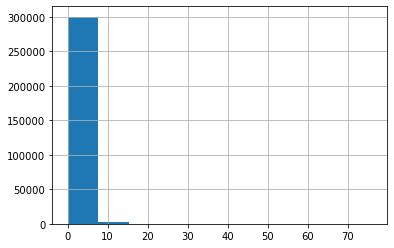

In [130]:
df_work['baths'].hist()

In [131]:
df_quantity_bathroom = pd.DataFrame(data = quantity_bath(df_work['baths']), columns = ['bathroom', '0.5_bathroom', '0.25_bathroom'])

In [132]:
df_quantity_bathroom['baths'] = df_work['baths'].copy()
df_quantity_bathroom['propertyType'] = df_work['propertyType'].copy()

In [133]:
df_quantity_bathroom

,bathroom,0.5_bathroom,0.25_bathroom,baths,propertyType
0,3.0,1.0,0.0,3.5,single family home
1,3.0,0.0,0.0,3.0,single family home
2,2.0,0.0,0.0,2.0,single family home
3,8.0,0.0,0.0,8.0,single family home
4,0.0,0.0,0.0,NaN,land
...,...,...,...,...,...
377180,6.0,0.0,0.0,6.0,single family home
377181,3.0,0.0,0.0,3.0,condo
377182,3.0,0.0,0.0,3.0,single family home
377183,0.0,0.0,0.0,NaN,other


In [134]:
# столбец bathroom - столбец с ранговыми переменными, в которой ранг 4 включает в себя объекты, 
#в которых более 3 ванн
df_quantity_bathroom['bathroom'] = df_quantity_bathroom['bathroom'].apply(lambda x: 4 if x > 3 else x) 

<AxesSubplot:>

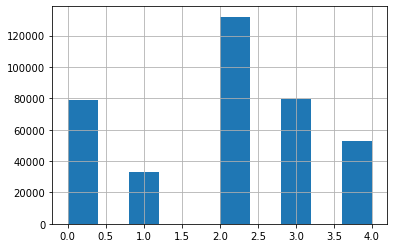

In [135]:
df_quantity_bathroom['bathroom'].hist()

<AxesSubplot:>

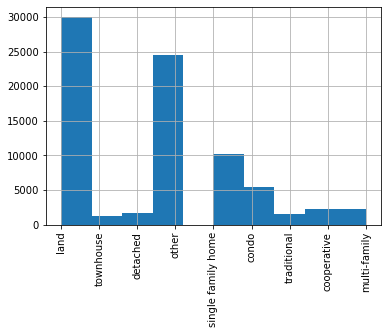

In [136]:
df_quantity_bathroom[df_quantity_bathroom['bathroom'] == 0]['propertyType'].hist(xrot = 90)

по типу продаваемой недвижисости максимальное число неразмеченных данных относится к категории "land". Для этой категории оставим 0 без изменения. Для остальных категорий заполним по 

In [137]:
index_bath = df_quantity_bathroom[df_quantity_bathroom['bathroom'] == 0].index
for i in tqdm(index_bath):
    if df_quantity_bathroom.loc[i, 'propertyType'] != 'land':
        var = df_quantity_bathroom.loc[i, 'propertyType']
        var_2 = int(df_quantity_bathroom[df_quantity_bathroom['propertyType'] == var]['bathroom'].mode())
        df_quantity_bathroom.loc[i, 'bathroom'] = var_2        

100%|██████████| 79115/79115 [31:20<00:00, 42.07it/s]


<AxesSubplot:>

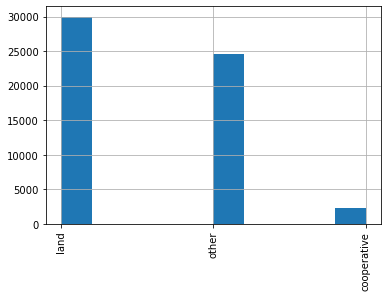

In [138]:
df_quantity_bathroom[df_quantity_bathroom['bathroom'] == 0]['propertyType'].hist(xrot = 90)

<AxesSubplot:>

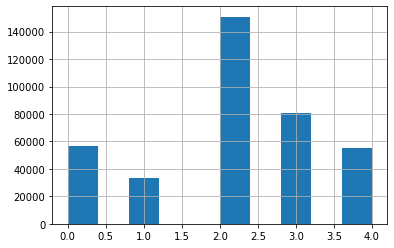

In [139]:
df_quantity_bathroom['bathroom'].hist()

In [140]:
index_bath = df_quantity_bathroom[df_quantity_bathroom['bathroom'] == 0].index
for i in tqdm(index_bath):
    var = df_work.loc[i, 'propertyType']
    var_2 = df_work[df_work['propertyType'] == var].index
    var_3 = df_quantity_bathroom.loc[var_2, 'bathroom'].mode()
    df_quantity_bathroom.loc[i, 'bathroom'] = int(var_3)

100%|██████████| 56779/56779 [52:37<00:00, 17.98it/s]  


<AxesSubplot:>

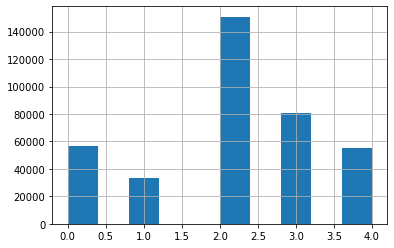

In [141]:
df_quantity_bathroom['bathroom'].hist()

In [142]:
index_bath_city = df_quantity_bathroom[df_quantity_bathroom['bathroom'] == 0].index # заполним столбец 
#bathroom с учетом населенности города 
for i in tqdm(index_bath_city):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_quantity_bathroom.loc[var, 'bathroom'].mode())
    df_quantity_bathroom.loc[i, 'bathroom'] = var_2

100%|██████████| 56779/56779 [16:33<00:00, 57.12it/s]


<AxesSubplot:>

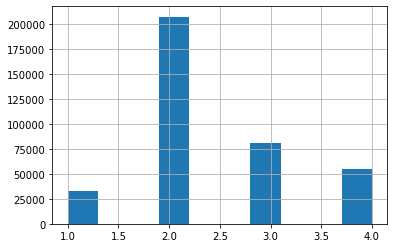

In [143]:
df_quantity_bathroom['bathroom'].hist()

In [144]:
df_quantity_bathroom

,bathroom,0.5_bathroom,0.25_bathroom,baths,propertyType
0,3.0,1.0,0.0,3.5,single family home
1,3.0,0.0,0.0,3.0,single family home
2,2.0,0.0,0.0,2.0,single family home
3,4.0,0.0,0.0,8.0,single family home
4,2.0,0.0,0.0,NaN,land
...,...,...,...,...,...
377180,4.0,0.0,0.0,6.0,single family home
377181,3.0,0.0,0.0,3.0,condo
377182,3.0,0.0,0.0,3.0,single family home
377183,2.0,0.0,0.0,NaN,other


In [145]:
#df_bath = df_quantity_bathroom.copy()

In [146]:
# Series df_quantity_bathroom переведем в dummis переменную
df_bathroom = pd.get_dummies(df_quantity_bathroom['bathroom'])
df_bathroom[['0.5', '0.25']] = df_quantity_bathroom[['0.5_bathroom', '0.25_bathroom']]

In [147]:
df_bathroom

,1.0,2.0,3.0,4.0,0.5,0.25
0,0,0,1,0,1.0,0.0
1,0,0,1,0,0.0,0.0
2,0,1,0,0,0.0,0.0
3,0,0,0,1,0.0,0.0
4,0,1,0,0,0.0,0.0
...,...,...,...,...,...,...
377180,0,0,0,1,0.0,0.0
377181,0,0,1,0,0.0,0.0
377182,0,0,1,0,0.0,0.0
377183,0,1,0,0,0.0,0.0


df_bathroom используется для дальнейшего обучения

### Столбцы private pool и PrivatePool

In [148]:
df_work[['private pool', 'PrivatePool']].head(10)

,private pool,PrivatePool
0,NaN,NaN
1,NaN,NaN
2,NaN,yes
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [149]:
df_work['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [150]:
df_work['PrivatePool'].value_counts()

yes    28793
Yes    11518
Name: PrivatePool, dtype: int64

In [151]:
df_work['PrivatePool'] = df_work['PrivatePool'].apply(lambda x: 'Yes' if x == 'yes' else x)

In [152]:
df_work['PrivatePool'].head(10)

0    NaN
1    NaN
2    Yes
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: PrivatePool, dtype: object

In [153]:
df_work['Pool'] = np.zeros((len(df_work), 1))

In [154]:
type(df_work.loc[2, 'PrivatePool'])

str

In [155]:
for i in tqdm(df_work.index):
    if type(df_work.loc[i, 'PrivatePool']) == str or type(df_work.loc[i, 'private pool']) == str:
        df_work.loc[i, 'Pool'] = 1

100%|██████████| 377185/377185 [01:59<00:00, 3166.95it/s]


In [156]:
df_work['Pool'].value_counts()

0.0    332693
1.0     44492
Name: Pool, dtype: int64

In [157]:
df_work[df_work['Pool'] == 1]['PrivatePool'].count()

40311

In [158]:
df_work[df_work['Pool'] == 1]['private pool'].count()

4181

In [159]:
df_work = df_work.drop(['PrivatePool', 'private pool'], axis = 1)

Series df_work['Pool'] используется при обучении

### Столбец beds

In [160]:
df_work['beds'].value_counts()

3 Beds         53459
4 Beds         35418
3              31406
2 Beds         26362
4              20030
               ...  
5,876 sqft         1
10.61 acres        1
99                 1
4,534 sqft         1
10.32 acres        1
Name: beds, Length: 1184, dtype: int64

In [161]:
df_work['beds'] = df_work['beds'].apply(lambda x: np.NaN if re.search('sqft', str(x)) != None else x)
df_work['beds'] = df_work['beds'].apply(lambda x: np.NaN if re.search('acre', str(x)) != None else x)
df_work['beds'] = df_work['beds'].apply(lambda x: 2 if re.search('2 Bedrooms', str(x)) != None else x)

In [162]:
df_work['beds'] = df_work['beds'].apply(lambda x: find_number_info(str(x)))

In [163]:
df_work['beds'].count()

265344

In [164]:
df_work['beds']  = mlsid_analysis (df_work, 'beds', unique_mlsid)

100%|██████████| 111841/111841 [59:54<00:00, 31.11it/s] 


In [165]:
df_work['beds'].count()

305295

<AxesSubplot:>

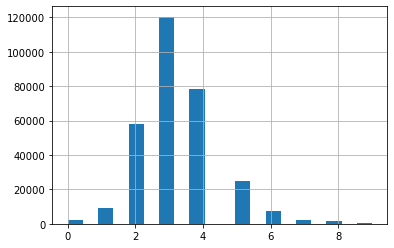

In [166]:
df_work[df_work['beds'] < 10]['beds'].hist(bins = 20)

In [167]:
#разделим данные по количеству спален на 5 групп: от 1 до 3 спален, 3 спальни, от 3 до 5 спелен, от 5 до 10, более 10
df_work['quan_beds'] = df_work['beds'].apply(lambda x: quantity_beds(x))

In [168]:
df_work[['beds', 'quan_beds']]

,beds,quan_beds
0,4.0,3
1,3.0,2
2,3.0,2
3,5.0,3
4,NaN,0
...,...,...
377180,5.0,3
377181,3.0,2
377182,3.0,2
377183,NaN,0


<AxesSubplot:>

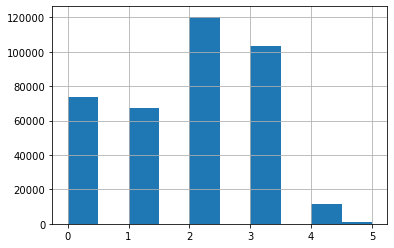

In [169]:
df_work['quan_beds'].hist()

<AxesSubplot:>

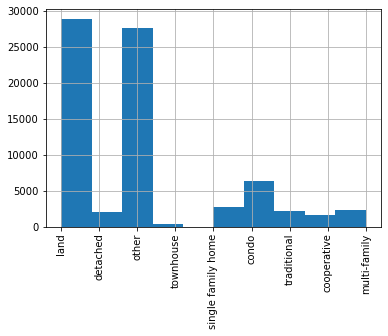

In [170]:
df_work[df_work['quan_beds'] == 0]['propertyType'].hist(xrot = 90)

In [171]:
index_beds = df_work[df_work['quan_beds'] == 0].index
for i in tqdm(index_beds):
    var = df_work.loc[i, 'propertyType']
    var_2 = int(df_work[df_work['propertyType'] == var]['quan_beds'].mode())
    df_work.loc[i, 'quan_beds'] = var_2

100%|██████████| 73944/73944 [1:02:13<00:00, 19.81it/s]


<AxesSubplot:>

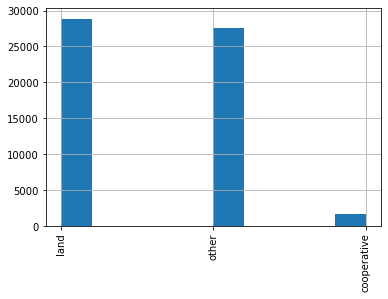

In [172]:
df_work[df_work['quan_beds'] == 0]['propertyType'].hist(xrot = 90)

<AxesSubplot:>

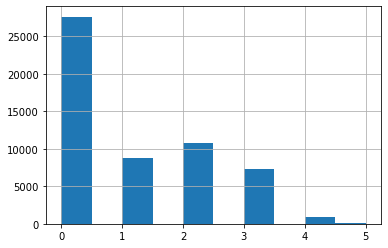

In [173]:
df_work[df_work['propertyType'] == 'other']['quan_beds'].hist()

<AxesSubplot:>

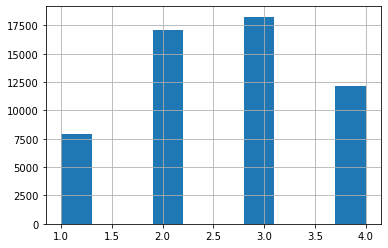

In [174]:
type_city_pop[df_work[df_work['propertyType'] == 'other'].index].hist()# рассмотрим распределение типа недвижимости от населения

In [175]:
index_beds_city = df_work[df_work['quan_beds'] == 0].index # заполним столбец 
#quan_beds с учетом населенности города 
for i in tqdm(index_beds_city):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_work.loc[var, 'quan_beds'].mode())
    df_work.loc[i, 'quan_beds'] = var_2

100%|██████████| 58048/58048 [16:04<00:00, 60.19it/s]


<AxesSubplot:>

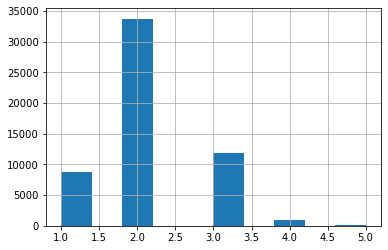

In [176]:
df_work[df_work['propertyType'] == 'other']['quan_beds'].hist()

<AxesSubplot:>

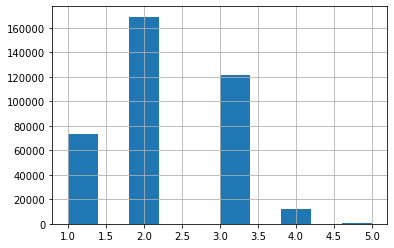

In [177]:
df_work['quan_beds'].hist()

In [178]:
# Преобразуем Series df_work['quan_beds'] в dummies переменную
df_quan_beds = pd.get_dummies(df_work['quan_beds'])
df_quan_beds

,1,2,3,4,5
0,0,0,1,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0
...,...,...,...,...,...
377180,0,0,1,0,0
377181,0,1,0,0,0
377182,0,1,0,0,0
377183,0,1,0,0,0


df_quan_beds используется для дальнейшего обучения

### Столбец fireplace

In [179]:
df_work['fireplace'].value_counts().head(10)

yes               50356
Yes               20856
1                 14544
2                  2432
Not Applicable     1993
Fireplace           847
3                   564
Living Room         433
LOCATION            399
Wood Burning        311
Name: fireplace, dtype: int64

Столбец содержит различную информацию: наличие камина, тип камина, комната расположения и т/д. Приведем все данны к одному измерению: наличие камина

In [180]:
df_work['fireplace'] = df_work['fireplace'].apply(lambda x: np.NaN if x in ['No', '0'] else x)

In [181]:
df_work['fireplace'] = df_work['fireplace'].fillna(0)

In [182]:
df_work['yes_fireplace'] = df_work['fireplace'].apply(lambda x: 1 if x != 0 else 0)

In [183]:
df_work[['fireplace', 'yes_fireplace']].head(40)

,fireplace,yes_fireplace
0,Gas Logs,1
1,0,0
2,yes,1
3,yes,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [184]:
df_work[df_work['yes_fireplace'] == 1]['yes_fireplace'].count()

102555

In [185]:
df_work['yes_fireplace'] = df_work['yes_fireplace'].apply(lambda x: np.NaN if x == 0 else x)

In [186]:
df_work['yes_fireplace']  = mlsid_analysis (df_work, 'yes_fireplace', unique_mlsid)

100%|██████████| 274630/274630 [1:55:08<00:00, 39.75it/s]  


In [187]:
df_work['yes_fireplace'].count()

116622

In [188]:
df_work['yes_fireplace'] = df_work['yes_fireplace'].fillna(0)

Series df_work['yes_fireplace'] используется для дальнейшего обучения

### Столбец sqft

In [189]:
df_work['sqft']

0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
4                NaN
             ...    
377180         4,017
377181    2,000 sqft
377182    1,152 sqft
377183           NaN
377184         1,462
Name: sqft, Length: 377185, dtype: object

In [190]:
df_work['sqft'] = df_work['sqft'].apply(lambda x : str(x).replace(',', ''))
df_work['sqft'] = df_work['sqft'].apply(lambda x : find_number_info(x))

In [191]:
df_work['sqft'].count()

335788

In [192]:
df_work['sqft'] = mlsid_analysis (df_work, 'sqft', unique_mlsid)

100%|██████████| 41397/41397 [15:15<00:00, 45.22it/s]


In [193]:
df_work['sqft'].count()

342802

In [194]:
# заполним пропуски с учетом типа недвижимости. Так как переменная количественная, используем mean
index_sqft = df_work[df_work['sqft'].isna() == True].index
for i in tqdm(index_sqft):
    var = df_work.loc[i, 'propertyType']
    var_2 = int(df_work[df_work['propertyType'] == var]['sqft'].mean())
    df_work.loc[i, 'sqft'] = var_2

100%|██████████| 34383/34383 [28:27<00:00, 20.14it/s]


In [195]:
df_work['sqft'].count()

377185

<AxesSubplot:>

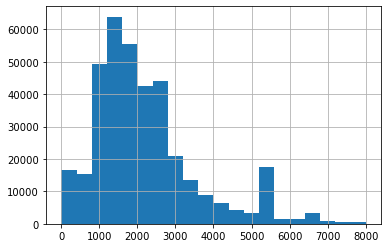

In [196]:
df_work[df_work['sqft'] < 0.8 * 10 ** 4]['sqft'].hist(bins=20)

In [197]:
df_work['sqft'].value_counts()

0.0        15976
5393.0     15234
2798.0     14024
6743.0      2424
1200.0      1442
           ...  
9733.0         1
21000.0        1
6567.0         1
14224.0        1
32767.0        1
Name: sqft, Length: 9898, dtype: int64

In [198]:
index_sqft_city = df_work[df_work['sqft'] == 0].index # заполним столбец 
#sqft с учетом населенности города 
for i in tqdm(index_sqft_city):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_work.loc[var, 'sqft'].mean())
    df_work.loc[i, 'sqft'] = var_2

100%|██████████| 15976/15976 [04:15<00:00, 62.60it/s]


<AxesSubplot:>

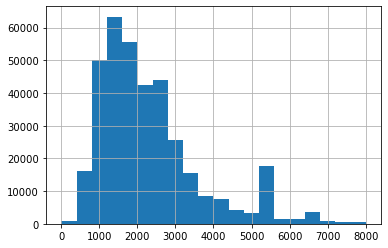

In [199]:
df_work[df_work['sqft'] < 0.8 * 10 ** 4]['sqft'].hist(bins=20)

In [200]:
df_work[df_work['sqft'] == 0]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,mls_id,Pool,quan_beds,yes_fireplace


Series df_work['sqft'] используется для дальнейшего обучения

### Столбец schools

In [201]:
df_work[df_work['schools'].isna() == True]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,mls_id,Pool,quan_beds,yes_fireplace


In [202]:
df_work['schools'].value_counts()

[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                                                                                                                                                                            4204
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]                                                                                                                                                                                                      222
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']},

In [203]:
df_work.loc[1,'schools'][df_work.loc[1,'schools'].find("'rating': [") + len("'rating': [") : df_work.loc[1,'schools'].rfind("], 'data")]

"'4/10', 'None/10', '4/10'"

In [204]:
df_work.loc[1,'schools']

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

In [205]:
#var = ['rating', 'Distance', 'Grades', 'name']
#df_school = data_school (df_work['schools'], var) №преобразование информации
#df_school_base.to_csv(DATA_PATH + 'df_school_base.csv')

In [206]:
 df_school_base = pd.read_csv(DATA_PATH + 'df_school_base.csv')

In [207]:
df_school = df_school_base.copy()

In [208]:
df_school['rating'] = df_school['rating'].apply(lambda x: x.split(',')) 
df_school['Distance'] = df_school['Distance'].apply(lambda x: x.split(',')) 
df_school['Grades'] = df_school['Grades'].apply(lambda x: x.split(',')) 
df_school['name'] = df_school['name'].apply(lambda x: x.split(','))

In [209]:
df_school['rating'] = df_school['rating'].apply(lambda x: find_number(x))
df_school['Distance'] = df_school['Distance'].apply(lambda x: find_number(x))

In [210]:
df_school.head(10)


,Unnamed: 0,rating,Distance,Grades,name
0,0,"[4.0, 4.0, 7.0, nan, 4.0, 7.0, nan, nan]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","['Southern Pines Elementary School', 'Souther..."
1,1,"[4.0, nan, 4.0]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastva..."
2,2,"[8.0, 4.0, 8.0]","[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scie..."
3,3,"[9.0, 9.0, 10.0, 9.0]","[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield ..."
4,4,"[4.0, 5.0, 5.0]","[5.96, 3.25, 3.03]","['7-8', '9-12', 'PK-6']","['Southwest Middle School', 'Bayside High Sch..."
5,5,[nan],[nan],[No inf],[No inf]
6,6,"[3.0, 3.0, 1.0, nan]","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to ...","['Palmetto Elementary School', 'Haines City S..."
7,7,"[4.0, 2.0, 2.0]","[0.7, 0.4, 2.2]","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mi..."
8,8,"[2.0, 2.0, 4.0, 7.0, 4.0, nan]","[5.6, 5.6, 6.8, 6.5, 6.8, 6.8]","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9...","['Roosevelt Elementary School', 'Lincoln Inte..."
9,9,"[4.0, 3.0, 2.0]","[0.7, 0.6, 1.9]","['PK-5', '5-8', '9-12']","['Edgewood Elementary School', 'Landrum Middl..."


In [211]:
# Рейтинг школ
df_rating_school = pd.DataFrame(data = np.zeros((len(df_school), 10)), columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
for i in range(len(df_school)):
    for j in range(1, 11):
        if j in df_school.loc[i, 'rating']:
            df_rating_school.loc[i, j] = 1
        else: df_rating_school.loc[i, j] = 0
df_rating_school # Используется при обучении

,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
377180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
377181,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
377182,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
377183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
df_school[name_grades] = school_grades_data(df_school['Grades'])

In [213]:
df_school['min_distance'] = df_school['Distance'].apply(lambda x: pd.Series(x).min())
df_school['mean_distance'] = df_school['Distance'].apply(lambda x: pd.Series(x).mean())
df_school['max_distance'] = df_school['Distance'].apply(lambda x: pd.Series(x).max())

In [214]:
name_grades_distance = ['p_distance','e_distance','m_distance','h_distance']#минимальное расстояние до школы с учетом grades
df_school[name_grades_distance] = school_gr_distance(df_school['Grades'], df_school['Distance'])

100%|██████████| 377185/377185 [03:54<00:00, 1609.62it/s]


In [215]:
df_school

,Unnamed: 0,rating,Distance,Grades,name,preschool,elementary_school,middle_school,high_school,min_distance,mean_distance,max_distance,p_distance,e_distance,m_distance,h_distance
0,0,"[4.0, 4.0, 7.0, nan, 4.0, 7.0, nan, nan]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","['Southern Pines Elementary School', 'Souther...",1.0,1.0,1.0,1.0,2.70,5.537500,12.60,2.70,2.70,3.10,3.10
1,1,"[4.0, nan, 4.0]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastva...",1.0,1.0,1.0,1.0,1.01,1.326667,1.65,1.01,1.01,1.01,1.65
2,2,"[8.0, 4.0, 8.0]","[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","['Paul Revere Middle School', 'Brentwood Scie...",0.0,1.0,1.0,1.0,1.19,1.960000,2.63,0.00,2.06,1.19,2.63
3,3,"[9.0, 9.0, 10.0, 9.0]","[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","['Mcculloch Intermediate School', 'Bradfield ...",1.0,1.0,1.0,1.0,0.10,0.752500,1.05,0.10,0.10,1.05,0.81
4,4,"[4.0, 5.0, 5.0]","[5.96, 3.25, 3.03]","['7-8', '9-12', 'PK-6']","['Southwest Middle School', 'Bayside High Sch...",1.0,1.0,1.0,1.0,3.03,4.080000,5.96,3.03,3.03,3.03,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,377180,"[10.0, 5.0]","[32.1, 1.1]","['PK-8', '9-12']","['Air Base Elementary School', 'Dr Michael M....",1.0,1.0,1.0,1.0,1.10,16.600000,32.10,32.10,32.10,32.10,1.10
377181,377181,"[1.0, 5.0, 7.0]","[10.61, 1.42, 0.4]","['9-12', '9-12', 'PK-8']","['Hope College Prep High School', 'Lake View ...",1.0,1.0,1.0,1.0,0.40,4.143333,10.61,0.40,0.40,0.40,1.42
377182,377182,"[5.0, 4.0]","[0.48, 0.73]","['PK-5', '6-8']","['Ps 48 William Wordsworth', 'Jhs 8 Richard S...",1.0,1.0,1.0,0.0,0.48,0.605000,0.73,0.48,0.48,0.73,0.00
377183,377183,"[nan, nan, nan]","[1.3, 0.5, 1.9]","['PK-5', '6-8', '9-12']","['Hiliard El', 'Forest Brook Middle', 'North...",1.0,1.0,1.0,1.0,0.50,1.233333,1.90,1.30,1.30,0.50,1.90


Разделение школ на частные и публичные

In [216]:
df_school['name'][8]

["'Roosevelt Elementary School'",
 " 'Lincoln Intermediate School'",
 " 'Mason City High School'",
 " 'Jefferson Elementary School'",
 " 'John Adams Middle School'",
 " 'Alternative School'"]

In [217]:
df_private_school = pd.read_csv(DATA_PATH + 'Private_Schools.csv')#таблица с данными о частных школах

In [218]:
df_private_school.head()

,X,Y,FID,OBJECTID,NCESID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,START_GRAD,END_GRADE,FT_TEACHER,SHELTER_ID
0,-8.136078e+06,5.055506e+06,1,1201,A0507274,A CHILD'S GARDEN,20 IVY BROOK RD,SHELTON,CT,6484,6418,NOT AVAILABLE,7,1,8,FAIRFIELD,9001,USA,41.291990,-73.087632,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY,2010/02/25 00:00:00,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,1,6,2,3,2,NOT AVAILABLE
1,-8.147300e+06,5.037067e+06,2,1202,A0500844,BRIDGEPORT INTERNATIONAL ACADEMY,285 LAFAYETTE ST STE 200,BRIDGEPORT,CT,6604,5755,NOT AVAILABLE,3,1,68,FAIRFIELD,9001,USA,41.167416,-73.188438,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY/OTHER,2010/02/23 00:00:00,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2,60,14,17,8,NOT AVAILABLE
2,-8.197042e+06,5.018050e+06,3,1203,A0108054,CARMEL ACADMEY,270 LAKE AVE,GREENWICH,CT,6830,4518,NOT AVAILABLE,3,1,278,FAIRFIELD,9001,USA,41.038690,-73.635283,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY,2010/03/05 00:00:00,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,1,225,3,13,53,NOT AVAILABLE
3,-8.171504e+06,5.077291e+06,4,1204,A0507283,COUNTRY KIDS CLUB,94 OLD STATE RD,BROOKFIELD,CT,6804,2524,NOT AVAILABLE,7,1,11,FAIRFIELD,9001,USA,41.438861,-73.405868,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,GEOCODE,2010/02/25 00:00:00,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,1,10,2,3,1,NOT AVAILABLE
4,-8.197596e+06,5.017131e+06,5,1205,01612613,EAGLE HILL SCHOOL,45 GLENVILLE RD,GREENWICH,CT,6831,NOT AVAILABLE,NOT AVAILABLE,4,1,318,FAIRFIELD,9001,USA,41.032465,-73.640254,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY/OTHER,2010/02/26 00:00:00,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,3,253,4,15,65,NOT AVAILABLE


In [219]:
df_private_school[df_private_school['CITY'].isna() != False]

,X,Y,FID,OBJECTID,NCESID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,START_GRAD,END_GRADE,FT_TEACHER,SHELTER_ID


In [220]:
len(df_private_school['CITY'].unique())

6163

In [221]:
df_public_school = pd.read_csv(DATA_PATH + 'Public_Schools.csv')#таблица с данными о публичных школах

In [222]:
df_public_school

,X,Y,OBJECTID,NCESID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,ST_GRADE,END_GRADE,DISTRICTID,FT_TEACHER,SHELTER_ID
0,-9.844095e+06,5.230976e+06,1,170330000017,ALDEN-HEBRON HIGH SCHOOL,9604 ILLINOIS ST,HEBRON,IL,60034,9618,(815) 648-2442,1,1,123,MCHENRY,17111,USA,42.465566,-88.431010,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2009/10/13 00:00:00,IMAGERY/OTHER,2010/08/27 00:00:00,NOT AVAILABLE,HIGH,112,09,12,1703300,11,NOT AVAILABLE
1,-9.007027e+06,4.195442e+06,2,370297001287,WESTERLY HILLS ACADEMY,4420 DENVER AVE,CHARLOTTE,NC,28208,3699,(980) 343-6021,1,1,540,MECKLENBURG,37119,USA,35.231909,-80.911501,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2009/12/10 00:00:00,IMAGERY/OTHER,2016/08/22 00:00:00,http://schools.cms.k12.nc.us/westerlyhillsES,ELEMENTARY,495,KG,08,3702970,45,NOT AVAILABLE
2,-9.580426e+06,4.792069e+06,3,180369000584,NORTHWOOD ELEMENTARY SCHOOL,965 GRIZZLY CUB DR,FRANKLIN,IN,46131,1364,(317) 346-8900,1,1,503,JOHNSON,18081,USA,39.489753,-86.062430,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2009/10/13 00:00:00,IMAGERY/OTHER,2010/08/02 00:00:00,NOT AVAILABLE,ELEMENTARY,478,PK,04,1803690,25,NOT AVAILABLE
3,-1.243297e+07,3.927588e+06,4,40187003479,DR. GARY AND ANNETTE AUXIER ELEMENTARY SCHOOL,22700 S. POWER RD.,QUEEN CREEK,AZ,85298,NOT AVAILABLE,(480) 812-7000,1,1,1009,MARICOPA,4013,USA,33.242888,-111.687306,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2018/10/23 00:00:00,IMAGERY/OTHER,2018/10/24 00:00:00,NOT AVAILABLE,ELEMENTARY,958,PK,06,401870,51,NOT AVAILABLE
4,-1.243258e+07,3.924831e+06,5,40187003483,DR. CAMILLE CASTEEL HIGH SCHOOL,24901 S. POWER RD.,QUEEN CREEK,AZ,85142,NOT AVAILABLE,(480) 424-8100,1,1,2409,MARICOPA,4013,USA,33.222170,-111.683768,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2018/10/23 00:00:00,IMAGERY/OTHER,2018/10/24 00:00:00,NOT AVAILABLE,HIGH,2294,07,12,401870,115,NOT AVAILABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102329,-1.075152e+07,5.688108e+06,102330,270015003019,LISMORE COLONY SCHOOL,80391 COUNTY RD 60,CLINTON,MN,56225,361,(320) 325-5583,1,1,38,BIG STONE,27011,USA,45.421397,-96.582510,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY/OTHER,2019/10/01 00:00:00,http://clintongraceville.mn.schoolwebpages.com,OTHER,36,KG,12,2700150,2,NOT AVAILABLE
102330,-1.031719e+07,4.598066e+06,102331,290699000174,OSAGE BEACH ELEM.,1241 NICHOLS ROAD,OSAGE BEACH,MO,65065,2172,(573) 348-2461,1,1,329,CAMDEN,29029,USA,38.131828,-92.680915,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2009/10/13 00:00:00,IMAGERY/OTHER,2019/12/31 00:00:00,http://www.camdentonschools.org,ELEMENTARY,307,PK,04,2906990,22,NOT AVAILABLE
102331,-8.512030e+06,4.450964e+06,102332,510264001238,POINT OPTION ALTERNATIVE SCHOOL,813 DILIGENCE DR.,NEWPORT NEWS,VA,23606,NOT AVAILABLE,(757) 591-7408,4,1,-999,NEWPORT NEWS,51700,USA,37.085021,-76.464870,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2009/10/13 00:00:00,IMAGERY/OTHER,2020/01/23 00:00:00,http://sbo.nn.k12.va.us/schools/pointoption.shtml,NOT APPLICABLE,-999,N,N,5102640,-999,NOT AVAILABLE
102332,-9.024169e+06,4.580376e+06,102333,540030000182,GATEWOOD ELEMENTARY,5094 GATEWOOD ROAD,FAYETTEVILLE,WV,25840,NOT AVAILABLE,(304) 574-2025,1,1,92,FAYETTE,54019,USA,38.006724,-81.065487,611110,ELEMENTARY AND SECONDARY SCHOOLS,http://nces.ed.gov/GLOBALLOCATOR/sch_info_popu...,2010/01/29 00:00:00,IMAGERY/OTHER,2020/03/23 00:00:00,NOT AVAILABLE,ELEMENTARY,85,PK,04,5400300,

In [223]:
(df_public_school['NAME'].str.find('TRENTWOOD') != -1).sort_values()

0         False
68226     False
68225     False
68224     False
68223     False
          ...  
34105     False
34104     False
34113     False
102333    False
93220      True
Name: NAME, Length: 102334, dtype: bool

In [224]:
df_public_school[df_public_school['NAME'].str.contains('TRENTWOOD') == True]['NAME']

93220    TRENTWOOD SCHOOL
Name: NAME, dtype: object

In [225]:
#df_type_school = type_school(df_school['name'],df_work['city'], df_public_school, df_private_school)
#df_type_school.to_csv(DATA_PATH + 'df_type_school.csv')

In [226]:
df_type_school = pd.read_csv(DATA_PATH + 'df_type_school.csv')
df_type_school = df_type_school.drop('Unnamed: 0', axis = 1)

In [227]:
df_type_school = df_type_school.rename(columns = {'0': 'type_school'})

In [228]:
df_type_school

,type_school
0,"[1, 1, 1, 1, 0, 0, 2, 2]"
1,"[0, 0, 1]"
2,"[1, 1, 0]"
3,"[1, 1, 1, 1]"
4,"[1, 1, 1]"
...,...
377180,"[0, 0]"
377181,"[1, 1, 1]"
377182,"[1, 1]"
377183,"[0, 1, 1]"


In [229]:
df_type_school[['distance','grades', 'rating']] = df_school[['Distance', 'Grades', 'rating']]

df_type_school['distance']


0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377180                                   [32.1, 1.1]
377181                            [10.61, 1.42, 0.4]
377182                                  [0.48, 0.73]
377183                               [1.3, 0.5, 1.9]
377184                               [0.3, 1.1, 4.1]
Name: distance, Length: 377185, dtype: object

In [230]:
find_type = '2'
df_type_school['private'] = df_type_school['type_school'].apply(lambda x: 1 if x.find(find_type) != -1 else 0)

In [231]:
df_type_school

,type_school,distance,grades,rating,private
0,"[1, 1, 1, 1, 0, 0, 2, 2]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","[4.0, 4.0, 7.0, nan, 4.0, 7.0, nan, nan]",1
1,"[0, 0, 1]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","[4.0, nan, 4.0]",0
2,"[1, 1, 0]","[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","[8.0, 4.0, 8.0]",0
3,"[1, 1, 1, 1]","[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","[9.0, 9.0, 10.0, 9.0]",0
4,"[1, 1, 1]","[5.96, 3.25, 3.03]","['7-8', '9-12', 'PK-6']","[4.0, 5.0, 5.0]",0
...,...,...,...,...,...
377180,"[0, 0]","[32.1, 1.1]","['PK-8', '9-12']","[10.0, 5.0]",0
377181,"[1, 1, 1]","[10.61, 1.42, 0.4]","['9-12', '9-12', 'PK-8']","[1.0, 5.0, 7.0]",0
377182,"[1, 1]","[0.48, 0.73]","['PK-5', '6-8']","[5.0, 4.0]",0
377183,"[0, 1, 1]","[1.3, 0.5, 1.9]","['PK-5', '6-8', '9-12']","[nan, nan, nan]",0


In [232]:
#Разделение информации по типу школы (публичная или частная)
type_school_info = pd.DataFrame(columns = ['distance_private_school', 'distance_public_school', 'grades_private_school', 'grades_public_school', 
                                            'rating_private_school', 'rating_public_school'])
for i in tqdm(range(len(df_type_school))):
    distance_private = []
    grades_private = []
    rating_private = []
    distance_public = []
    grades_public = []
    rating_public = []
    if type(df_type_school.loc[i, 'type_school']) == list:
        match = df_type_school.loc[i, 'type_school']
    else: match = re.findall('\d+', df_type_school.loc[i, 'type_school'])
    for j in range(len(match)):
        if j <= (len(df_type_school.loc[i, 'distance']) -1 ):
            if match[j].find('2') != -1:
                distance_private.append(df_type_school.loc[i, 'distance'][j])
            else: distance_public.append(df_type_school.loc[i, 'distance'][j])
        else:
            distance_private.append(0)
            distance_public.append(0) 
        if j <= (len(df_type_school.loc[i, 'grades']) -1):
            if match[j].find('2') != -1:
                grades_private.append(df_type_school.loc[i, 'grades'][j])
            else: grades_public.append(df_type_school.loc[i, 'grades'][j])
        else:
            grades_private.append(0)
            grades_public.append(0)
        if j <= (len(df_type_school.loc[i, 'rating']) - 1):
            if match[j].find('2') != -1:
                rating_private.append(df_type_school.loc[i, 'rating'][j])
            else: rating_public.append(df_type_school.loc[i, 'rating'][j])
        else:
            rating_private.append(0)
            rating_public.append(0)         
    type_school_info.loc[i, 'distance_private_school'] = distance_private
    type_school_info.loc[i, 'distance_public_school'] = distance_public
    type_school_info.loc[i, 'grades_private_school'] = grades_private
    type_school_info.loc[i, 'grades_public_school'] = grades_public
    type_school_info.loc[i, 'rating_private_school'] = rating_private
    type_school_info.loc[i, 'rating_public_school'] = rating_public
display(type_school_info)

100%|██████████| 377185/377185 [5:09:27<00:00, 20.31it/s]  


,distance_private_school,distance_public_school,grades_private_school,grades_public_school,rating_private_school,rating_public_school
0,"[2.7, 3.1]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6]","[ 'PK–5', 'K–12']","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","[nan, nan]","[4.0, 4.0, 7.0, nan, 4.0, 7.0]"
1,[],"[1.65, 1.32, 1.01]",[],"['9-12', '3-8', 'PK-8']",[],"[4.0, nan, 4.0]"
2,[],"[1.19, 2.06, 2.63]",[],"['6-8', 'K-5', '9-12']",[],"[8.0, 4.0, 8.0]"
3,[],"[1.05, 0.1, 1.05, 0.81]",[],"['5-6', 'PK-4', '7-8', '9-12']",[],"[9.0, 9.0, 10.0, 9.0]"
4,[],"[5.96, 3.25, 3.03]",[],"['7-8', '9-12', 'PK-6']",[],"[4.0, 5.0, 5.0]"
...,...,...,...,...,...,...
377180,[],"[32.1, 1.1]",[],"['PK-8', '9-12']",[],"[10.0, 5.0]"
377181,[],"[10.61, 1.42, 0.4]",[],"['9-12', '9-12', 'PK-8']",[],"[1.0, 5.0, 7.0]"
377182,[],"[0.48, 0.73]",[],"['PK-5', '6-8']",[],"[5.0, 4.0]"
377183,[],"[1.3, 0.5, 1.9]",[],"['PK-5', '6-8', '9-12']",[],"[nan, nan, nan]"


In [233]:
type_school_info[['quantity_private', 'quantity_public']] = np.zeros((len(type_school_info), 2))

In [234]:
for i in tqdm(range(len(type_school_info))):
    q_publice = 0
    q_private = 0
    if type(df_type_school.loc[i, 'type_school']) == list:
        match = df_type_school.loc[i, 'type_school']
    else: match = re.findall('\d+', df_type_school.loc[i, 'type_school'])
    for j in match:
        if j.find('2') != -1:
            q_private += 1
        else: q_publice += 1
    type_school_info.loc[i, 'quantity_private'] = q_private
    type_school_info.loc[i, 'quantity_public'] = q_publice

100%|██████████| 377185/377185 [35:19<00:00, 177.98it/s]


In [235]:
display(type_school_info)

,distance_private_school,distance_public_school,grades_private_school,grades_public_school,rating_private_school,rating_public_school,quantity_private,quantity_public
0,"[2.7, 3.1]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6]","[ 'PK–5', 'K–12']","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","[nan, nan]","[4.0, 4.0, 7.0, nan, 4.0, 7.0]",2.0,6.0
1,[],"[1.65, 1.32, 1.01]",[],"['9-12', '3-8', 'PK-8']",[],"[4.0, nan, 4.0]",0.0,3.0
2,[],"[1.19, 2.06, 2.63]",[],"['6-8', 'K-5', '9-12']",[],"[8.0, 4.0, 8.0]",0.0,3.0
3,[],"[1.05, 0.1, 1.05, 0.81]",[],"['5-6', 'PK-4', '7-8', '9-12']",[],"[9.0, 9.0, 10.0, 9.0]",0.0,4.0
4,[],"[5.96, 3.25, 3.03]",[],"['7-8', '9-12', 'PK-6']",[],"[4.0, 5.0, 5.0]",0.0,3.0
...,...,...,...,...,...,...,...,...
377180,[],"[32.1, 1.1]",[],"['PK-8', '9-12']",[],"[10.0, 5.0]",0.0,2.0
377181,[],"[10.61, 1.42, 0.4]",[],"['9-12', '9-12', 'PK-8']",[],"[1.0, 5.0, 7.0]",0.0,3.0
377182,[],"[0.48, 0.73]",[],"['PK-5', '6-8']",[],"[5.0, 4.0]",0.0,2.0
377183,[],"[1.3, 0.5, 1.9]",[],"['PK-5', '6-8', '9-12']",[],"[nan, nan, nan]",0.0,3.0


In [236]:
type_school_info.to_csv(DATA_PATH + 'type_school_info.csv')

In [237]:
df_private_school = type_school_info[['distance_private_school', 'grades_private_school', 'rating_private_school', 'quantity_private']].copy()
df_private_school['private'] = df_type_school['private'].copy()

In [238]:
df_private_school[name_grades] = school_grades_data(df_private_school['grades_private_school'])

In [239]:
df_private_school['min_distance'] = df_private_school['distance_private_school'].apply(lambda x: pd.Series(x).min())
df_private_school['mean_distance'] = df_private_school['distance_private_school'].apply(lambda x: pd.Series(x).mean())
df_private_school['max_distance'] = df_private_school['distance_private_school'].apply(lambda x: pd.Series(x).max())

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [240]:
df_private_school

,distance_private_school,grades_private_school,rating_private_school,quantity_private,private,preschool,elementary_school,middle_school,high_school,min_distance,mean_distance,max_distance
0,"[2.7, 3.1]","[ 'PK–5', 'K–12']","[nan, nan]",2.0,1,1.0,1.0,1.0,1.0,2.7,2.9,3.1
1,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377180,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
377181,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
377182,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
377183,[],[],[],0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [241]:
df_private_school.to_csv(DATA_PATH + 'df_private_school.csv')

In [242]:
type_school_info = type_school_info.rename(columns = {'quantity_publice' : 'quantity_public'} )

In [243]:
df_public_school = type_school_info[['distance_public_school', 'grades_public_school', 'rating_public_school', 'quantity_public']].copy()

In [244]:
df_public_school['public'] = df_public_school['quantity_public'].apply(lambda x: 1 if x != 0 else 0)

In [245]:
df_public_school[name_grades] = school_grades_data(df_public_school['grades_public_school'])

In [246]:
df_public_school['min_distance'] = df_public_school['distance_public_school'].apply(lambda x: pd.Series(x).min())
df_public_school['mean_distance'] = df_public_school['distance_public_school'].apply(lambda x: pd.Series(x).mean())
df_public_school['max_distance'] = df_public_school['distance_public_school'].apply(lambda x: pd.Series(x).max())

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [247]:
df_public_school

,distance_public_school,grades_public_school,rating_public_school,quantity_public,public,preschool,elementary_school,middle_school,high_school,min_distance,mean_distance,max_distance
0,"[2.7, 3.6, 5.1, 4.0, 10.5, 12.6]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–...","[4.0, 4.0, 7.0, nan, 4.0, 7.0]",6.0,1,1.0,1.0,1.0,1.0,2.70,6.416667,12.60
1,"[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","[4.0, nan, 4.0]",3.0,1,1.0,1.0,1.0,1.0,1.01,1.326667,1.65
2,"[1.19, 2.06, 2.63]","['6-8', 'K-5', '9-12']","[8.0, 4.0, 8.0]",3.0,1,0.0,1.0,1.0,1.0,1.19,1.960000,2.63
3,"[1.05, 0.1, 1.05, 0.81]","['5-6', 'PK-4', '7-8', '9-12']","[9.0, 9.0, 10.0, 9.0]",4.0,1,1.0,1.0,1.0,1.0,0.10,0.752500,1.05
4,"[5.96, 3.25, 3.03]","['7-8', '9-12', 'PK-6']","[4.0, 5.0, 5.0]",3.0,1,1.0,1.0,1.0,1.0,3.03,4.080000,5.96
...,...,...,...,...,...,...,...,...,...,...,...,...
377180,"[32.1, 1.1]","['PK-8', '9-12']","[10.0, 5.0]",2.0,1,1.0,1.0,1.0,1.0,1.10,16.600000,32.10
377181,"[10.61, 1.42, 0.4]","['9-12', '9-12', 'PK-8']","[1.0, 5.0, 7.0]",3.0,1,1.0,1.0,1.0,1.0,0.40,4.143333,10.61
377182,"[0.48, 0.73]","['PK-5', '6-8']","[5.0, 4.0]",2.0,1,1.0,1.0,1.0,0.0,0.48,0.605000,0.73
377183,"[1.3, 0.5, 1.9]","['PK-5', '6-8', '9-12']","[nan, nan, nan]",3.0,1,1.0,1.0,1.0,1.0,0.50,1.233333,1.90


In [248]:
df_public_school.to_csv(DATA_PATH + 'df_public_school.csv')

### Столбец homeFacts

In [249]:
df_home_info = pd.DataFrame(columns = ['year_built', 'remodeled_year', 'heating', 'cooling', 'parking', 'lotsize', 'price/sqft'])

In [250]:
#### Код для преобразования информации в Series  homefact
#for i in tqdm(range(len(df_work))):
    #chars = ["'", ":"]
    #if df_work.loc[i, 'homeFacts'].find('atAGlanceFacts') != -1:
        #list_home_info = re.split('}, {', df_work.loc[i, 'homeFacts'][21:-2])
        #for j in list_home_info:
            #j= j.replace('factValue', '')
            #j = j.replace('factLabel', '')
            #info = ''
            #for k in range(len(j)):
                #if j[k] in chars:
                    #info += ''.join('')
                #else: info += ''.join(j[k]) 
            #list_single_info = info.split(', ')
            #if list_single_info[-1].find('ear') != -1 and list_single_info[-1].find('buil') != -1: #столбец year_built
                #df_home_info.loc[i, 'year_built'] = find_number_info(list_single_info[0])
            #elif list_single_info[-1].find('ear') != -1 and list_single_info[-1].find('model') != -1: #столбец remodeled_year
                #df_home_info.loc[i, 'remodeled_year'] = find_number_info(list_single_info[0])
            #elif list_single_info[-1].find('eatin') != -1: #столбец heating
                #list_heating = []
                #if len(list_single_info) > 2:
                    #for k in range(len(list_single_info) -1) :
                        #list_heating.append(find_text_info(list_single_info[k]))
                #else:
                    #list_heating.append(find_text_info(list_single_info[0]))
                #if len(list_heating) == 1 and type(list_heating[0]) == float:
                     #df_home_info.loc[i, 'heating'] = np.NaN
                #else: df_home_info.loc[i, 'heating'] = list_heating
            #elif list_single_info[-1].find('olin') != -1: #столбец cooling
                #list_cooling = []
                #if len(list_single_info) > 2:
                    #for k in range(len(list_single_info) -1) :
                        #list_cooling.append(find_text_info(list_single_info[k])) 
                #else:
                    #list_cooling.append(find_text_info(list_single_info[0]))
                #if len(list_cooling) == 1 and type(list_cooling[0]) == float:
                     #df_home_info.loc[i, 'cooling'] = np.NaN
                #else: df_home_info.loc[i, 'cooling'] = list_cooling
            #elif list_single_info[-1].find('arkin') != -1: #столбец parking
                #list_parking = []
                #if len(list_single_info) > 2:
                    #for k in range(len(list_single_info) -1) :
                        #list_parking.append(find_text_info(list_single_info[k])) 
                #else:
                    #list_parking.append(find_text_info(list_single_info[0]))
                #if len(list_parking) == 1 and type(list_parking[0]) == float:
                    #df_home_info.loc[i, 'parking'] = np.NaN
                #else: df_home_info.loc[i, 'parking'] = list_parking
            #elif list_single_info[-1].find('siz') != -1: # столбец lotsize
                #df_home_info.loc[i, 'lotsize'] = find_number_info(list_single_info[0])
            #elif list_single_info[-1].find('ric') != -1 and list_single_info[-1].find('sqf') != -1: # столбец price/sqft
                #df_home_info.loc[i, 'price/sqft'] = find_number_info(list_single_info[0])
#df_home_info.to_csv(DATA_PATH + 'df_home_info.csv')

In [251]:
df_home_info = pd.read_csv(DATA_PATH + 'df_home_info.csv')

In [252]:
df_home_info

,Unnamed: 0,year_built,remodeled_year,heating,cooling,parking,lotsize,price/sqft
0,0,2019.0,NaN,"['Central A/C', 'Heat Pump']",NaN,NaN,NaN,144.0
1,1,2019.0,NaN,NaN,NaN,NaN,5828.000,159.0
2,2,1961.0,1967.0,['Forced Air'],NaN,['Attached Garage'],8.626,965.0
3,3,2006.0,2006.0,['Forced Air'],NaN,['Detached Garage'],8.220,371.0
4,4,NaN,NaN,NaN,NaN,NaN,10.019,NaN
...,...,...,...,...,...,...,...,...
377180,377180,1990.0,1990.0,NaN,NaN,['2 spaces'],8.500,311.0
377181,377181,1924.0,NaN,NaN,NaN,NaN,NaN,337.0
377182,377182,1950.0,1950.0,NaN,NaN,NaN,1.600,458.0
377183,377183,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
df_home_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      377185 non-null  int64  
 1   year_built      313589 non-null  float64
 2   remodeled_year  151075 non-null  float64
 3   heating         202334 non-null  object 
 4   cooling         77718 non-null   object 
 5   parking         180084 non-null  object 
 6   lotsize         281330 non-null  float64
 7   price/sqft      311248 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 23.0+ MB


In [254]:
df_home_info[['city', 'MlsId']] = df_work[['city', 'MlsId']].copy()

In [255]:
#столбец 'year_built'
df_home_info['year_built'].describe()

count    3.135890e+05
mean     3.573473e+06
std      1.414212e+09
min      1.000000e+00
25%      1.956000e+03
50%      1.985000e+03
75%      2.007000e+03
max      5.599906e+11
Name: year_built, dtype: float64

In [256]:
df_home_info['year_built'].value_counts()

2019.0    32171
2006.0     8008
2005.0     7503
2007.0     7152
2018.0     6857
          ...  
1805.0        1
1807.0        1
1808.0        1
1809.0        1
1019.0        1
Name: year_built, Length: 228, dtype: int64

In [257]:
df_home_info['year_built'].count()

313589

In [258]:
df_home_info[df_home_info['year_built'] == df_home_info['year_built'].max()]

,Unnamed: 0,year_built,remodeled_year,heating,cooling,parking,lotsize,price/sqft,city,MlsId
77801,77801,5.599906e+11,NaN,NaN,NaN,NaN,NaN,437.0,Seattle,161732709
354143,354143,5.599906e+11,NaN,NaN,NaN,NaN,NaN,454.0,Seattle,161732708


In [259]:
df.loc[77801, 'homeFacts']

"{'atAGlanceFacts': [{'factValue': '559990649990', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$437', 'factLabel': 'Price/sqft'}]}"

In [260]:
df_home_info[df_home_info['year_built'] == df_home_info['year_built'].min()]

,Unnamed: 0,year_built,remodeled_year,heating,cooling,parking,lotsize,price/sqft,city,MlsId
120342,120342,1.0,1111.0,NaN,NaN,NaN,12.59,5.95,Nashville,1997063
179746,179746,1.0,NaN,NaN,NaN,NaN,0.48,7.00,Pensacola,501274


<AxesSubplot:>

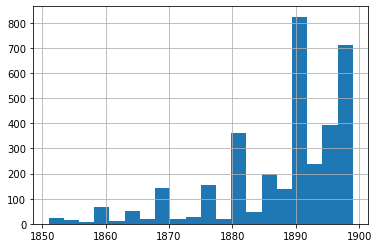

In [261]:
df_home_info[(df_home_info['year_built'] < 1900) & (df_home_info['year_built'] >1.85 * 10**3)]['year_built'].hist(bins = 20)

<AxesSubplot:>

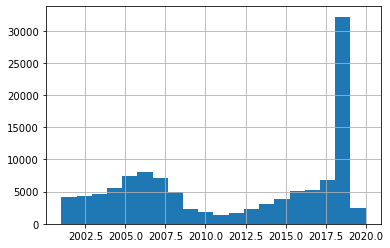

In [262]:
df_home_info[(df_home_info['year_built'] < 2021) & (df_home_info['year_built'] > 2000)]['year_built'].hist(bins = 20)

<AxesSubplot:>

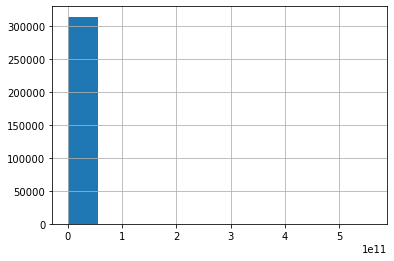

In [263]:
df_home_info['year_built'].hist()

In [264]:
df_home_info

,Unnamed: 0,year_built,remodeled_year,heating,cooling,parking,lotsize,price/sqft,city,MlsId
0,0,2019.0,NaN,"['Central A/C', 'Heat Pump']",NaN,NaN,NaN,144.0,Southern Pines,611019
1,1,2019.0,NaN,NaN,NaN,NaN,5828.000,159.0,Spokane Valley,201916904
2,2,1961.0,1967.0,['Forced Air'],NaN,['Attached Garage'],8.626,965.0,Los Angeles,FR19221027
3,3,2006.0,2006.0,['Forced Air'],NaN,['Detached Garage'],8.220,371.0,Dallas,14191809
4,4,NaN,NaN,NaN,NaN,NaN,10.019,NaN,Palm Bay,861745
...,...,...,...,...,...,...,...,...,...,...
377180,377180,1990.0,1990.0,NaN,NaN,['2 spaces'],8.500,311.0,Aventura,A10702700
377181,377181,1924.0,NaN,NaN,NaN,NaN,NaN,337.0,Chicago,10374233
377182,377182,1950.0,1950.0,NaN,NaN,NaN,1.600,458.0,Jamaica,NaN
377183,377183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Houston,NaN


In [265]:
#примем срок постройки 2022 как самый поздний, 1850 - как минимальный
df_home_info['year_built'] = df_home_info['year_built'].apply(lambda x: np.NaN if x < 1850 else x)
df_home_info['year_built'] = df_home_info['year_built'].apply(lambda x: np.NaN if x > 2022 else x)

In [266]:
df_home_info['year_built'].count()

313385

In [267]:
#Столбец remodeled_year
df_home_info['remodeled_year'].value_counts()

2006.0    5538
2005.0    4817
2007.0    4387
2008.0    3796
2004.0    3371
          ... 
1845.0       1
1800.0       1
1738.0       1
1111.0       1
1888.0       1
Name: remodeled_year, Length: 153, dtype: int64

In [268]:
df_home_info['remodeled_year'].count()

151075

In [269]:
#примем срок реконструкции 2021 как самый поздний, 1850 - как минимальный
df_home_info['remodeled_year'] = df_home_info['remodeled_year'].apply(lambda x: np.NaN if x < 1850 else x)
df_home_info['remodeled_year'] = df_home_info['remodeled_year'].apply(lambda x: np.NaN if x > 2021 else x)

<AxesSubplot:>

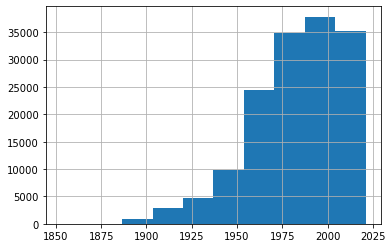

In [270]:
df_home_info['remodeled_year'].hist()

In [271]:
#Столбец lotsize не будем рассматривать. Есть столбец sqft в таблице df_work
df_home_info['lotsize'].value_counts()

2.600000e-01    3428
2.500000e-01    3013
2.800000e-01    2861
2.700000e-01    2723
2.900000e-01    2577
                ... 
9.546200e+04       1
4.773000e+04       1
2.041000e+01       1
1.193100e+04       1
2.147484e+09       1
Name: lotsize, Length: 23936, dtype: int64

In [272]:
#Столбец price/sqft
df_home_info['price/sqft'].value_counts()

125.000     1722
121.000     1710
128.000     1708
123.000     1702
127.000     1697
            ... 
6.120          1
1980.000       1
2.351          1
2470.000       1
1288.000       1
Name: price/sqft, Length: 3489, dtype: int64

In [273]:
df_home_info['price/sqft'].count()

311248

In [274]:
df_home_info['price/sqft'][df_home_info['price/sqft'] == df_home_info['price/sqft'].max()]

322852    5000000.0
Name: price/sqft, dtype: float64

In [275]:
df_work.loc[322852, :]

status                                                      active
propertyType                                                 other
street                                    2023-2025 Benning Rd NE 
baths                                                          1.5
homeFacts        {'atAGlanceFacts': [{'factValue': '1927', 'fac...
fireplace                                                        0
city                                                    Washington
schools          [{'rating': ['3', '3', '4'], 'data': {'Distanc...
sqft                                                             1
zipcode                                                      20002
beds                                                             3
state                                                           DC
stories                                                        NaN
MlsId                                                   1000255022
target                                                   5,000

для строки 322852 цена за квадратный фут равна общей стоимости. Площадь задана, как 1. Оставим эту позицию без изменений

<AxesSubplot:>

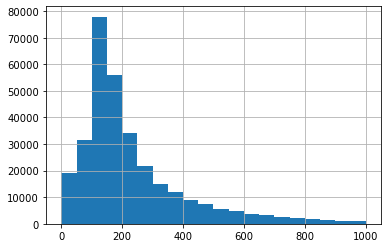

In [276]:
df_home_info[df_home_info['price/sqft'] < 1000]['price/sqft'].hist(bins = 20)

In [277]:
#Проверка по mlsid
for i in ['year_built', 'remodeled_year', 'price/sqft']:
    df_home_info[i]  = mlsid_analysis (df_home_info, i, unique_mlsid)

100%|██████████| 65937/65937 [23:36<00:00, 46.56it/s]


In [278]:
df_home_info['year_built'].count()

315825

In [279]:
df_home_info['remodeled_year'].count()

167790

In [280]:
df_home_info['price/sqft'].count()

314262

In [281]:
index_year_built = df_home_info[df_home_info['year_built'].isna() == True].index # заполним столбец 
#sqft с учетом населенности города 
for i in tqdm(index_year_built):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_home_info.loc[var, 'year_built'].mode())
    df_home_info.loc[i, 'year_built'] = var_2

100%|██████████| 61360/61360 [19:10<00:00, 53.36it/s]


In [282]:
df_home_info['year_built'].count()

377185

<AxesSubplot:>

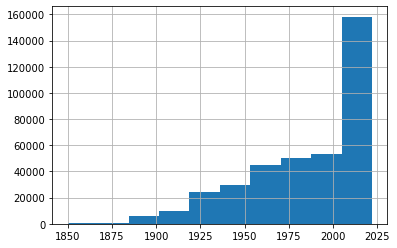

In [283]:
df_home_info['year_built'].hist()

In [284]:
index_price_sqft = df_home_info[df_home_info['price/sqft'].isna() == True].index # заполним столбец 
#sqft с учетом населенности города 
for i in tqdm(index_year_built):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_home_info.loc[var, 'price/sqft'].mean())
    df_home_info.loc[i, 'price/sqft'] = var_2

100%|██████████| 61360/61360 [17:26<00:00, 58.61it/s]


<AxesSubplot:>

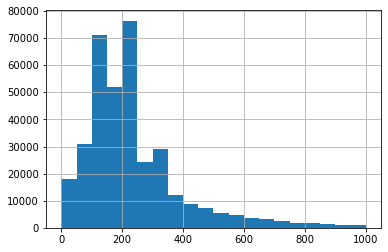

In [285]:
df_home_info[df_home_info['price/sqft'] < 1000]['price/sqft'].hist(bins = 20)

Series df_home_info['year_built'], df_home_info['remodeled_year'] и df_home_info['price/sqft'] используются для обучения

In [286]:
# столбцы heating, cooling, parking
df_home_info['heating'] = df_home_info['heating'].apply(lambda x: 0 if type(x) == float else 1)
df_home_info['cooling'] = df_home_info['cooling'].apply(lambda x: 0 if type(x) == float else 1)
df_home_info['parking'] = df_home_info['parking'].apply(lambda x: 0 if type(x) == float else 1)

In [287]:
df_home_info[['heating', 'cooling', 'parking']]

,heating,cooling,parking
0,1,0,0
1,0,0,0
2,1,0,1
3,1,0,1
4,0,0,0
...,...,...,...
377180,0,0,1
377181,0,0,0
377182,0,0,0
377183,0,0,0


In [288]:
df_home_info['heating'] = df_home_info['heating'].apply(lambda x: np.NaN if x == 0 else x)
df_home_info['cooling'] = df_home_info['cooling'].apply(lambda x: np.NaN if x == 0 else x)
df_home_info['parking'] = df_home_info['parking'].apply(lambda x: np.NaN if x == 0 else x)

In [289]:
for i in ['heating', 'cooling', 'parking']:
    df_home_info[i]  = mlsid_analysis (df_home_info, i, unique_mlsid)

100%|██████████| 197101/197101 [1:28:17<00:00, 37.21it/s]


Series df_home_info['heating'], df_home_info['cooling'], df_home_info['parking'] используются для дальнейшего обучения

### Столбец target

In [290]:
df_work['target'].value_counts()

$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
            ... 
$12,462        1
$392,614       1
$176,977       1
$178,322       1
525,909        1
Name: target, Length: 43939, dtype: int64

In [291]:
df_work['target'].count()

374704

In [292]:
df_work['target'] = df_work['target'].apply(lambda x: str(x).replace(',',''))
df_work['target'] = df_work['target'].apply(lambda x: find_number_info(x))

<AxesSubplot:>

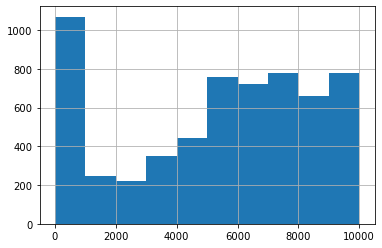

In [293]:
df_work[df_work['target'] < 10000]['target'].hist()

In [294]:
# Назначим NaN для цен меньше 10000
df_work['target'] = df_work['target'].apply(lambda x: np.NaN if x < 10000 else x)

In [295]:
df_work['target'].count()

368670

In [296]:
df_work['target'] = mlsid_analysis (df_work, 'target', unique_mlsid)

100%|██████████| 8515/8515 [01:41<00:00, 84.22it/s] 


In [297]:
df_work['target'].count()

368684

In [298]:
df_work['target'] = df_work['target'].astype(float)

<AxesSubplot:>

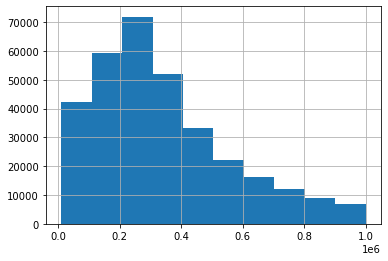

In [299]:
df_work[df_work['target'] < 1000000]['target'].hist()

<AxesSubplot:>

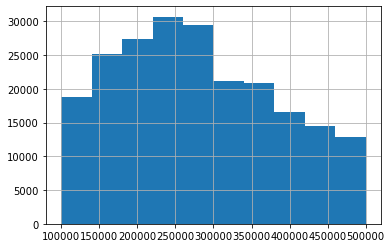

In [300]:
df_work[(df_work['target'] < 500000) & (df_work['target'] > 100000)]['target'].hist()

In [301]:
df_work['target'].max()

195000000.0

In [302]:
df_work['target'].sort_values(ascending = False).head()

132425    195000000.0
143528    165000000.0
285993    165000000.0
110083    150000000.0
178931    129000000.0
Name: target, dtype: float64

In [303]:
df.loc[132425,:]

status                                                   For sale
private pool                                                  NaN
propertyType                                        Single Family
street                                               875 Nimes Rd
baths                                                        18.0
homeFacts       {'atAGlanceFacts': [{'factValue': '1935', 'fac...
fireplace                                                     Yes
city                                                  Los Angeles
schools         [{'rating': ['10/10', '7/10'], 'data': {'Dista...
sqft                                                           --
zipcode                                                     90077
beds                                                           11
state                                                          CA
stories                                                         2
mls-id                                                        NaN
PrivatePoo

In [304]:
df.loc[285993,:]

status                                                   For sale
private pool                                                  NaN
propertyType                                        Single Family
street                                         67 Beverly Park Ct
baths                                                        23.0
homeFacts       {'atAGlanceFacts': [{'factValue': '1998', 'fac...
fireplace                                                     Yes
city                                                Beverly Hills
schools         [{'rating': ['10/10', '5/10', '7/10'], 'data':...
sqft                                                       28,660
zipcode                                                     90210
beds                                                           20
state                                                          CA
stories                                                         3
mls-id                                                        NaN
PrivatePoo

В данных присутствует информация о жилье со стоимостью намного выше средней цены. Данные по цене оставим без изменения. 

In [305]:
df_work['target'].sort_values(ascending = False).head(50)

132425    195000000.0
143528    165000000.0
285993    165000000.0
110083    150000000.0
178931    129000000.0
294206    115000000.0
119862    115000000.0
54164     110000000.0
354264    110000000.0
151594     98000000.0
357248     88000000.0
367477     87000000.0
279166     85000000.0
273381     82500000.0
370179     82500000.0
257052     78000000.0
356150     78000000.0
71787      75000000.0
309253     75000000.0
63865      75000000.0
87722      75000000.0
318465     69975000.0
152218     69950000.0
257254     67000000.0
22910      67000000.0
74608      65000000.0
175333     65000000.0
334237     65000000.0
224339     65000000.0
67112      65000000.0
181912     63815000.0
332726     63815000.0
308597     63750000.0
14026      63750000.0
283836     63000000.0
51470      60000000.0
231282     60000000.0
262646     60000000.0
294090     59995000.0
7166       59900000.0
253888     59000000.0
159559     59000000.0
274381     59000000.0
169210     58500000.0
218829     58500000.0
33133     

In [306]:
df.loc[252299,:]

status                                                foreclosure
private pool                                                  NaN
propertyType                                             lot/land
street                                       8136 Bradyville Pike
baths                                                         NaN
homeFacts       {'atAGlanceFacts': [{'factValue': '2005', 'fac...
fireplace                                                     NaN
city                                                 Murfreesboro
schools         [{'rating': ['5/10', '7/10', '7/10'], 'data': ...
sqft                                                          NaN
zipcode                                                     37127
beds                                                          NaN
state                                                          TN
stories                                                       NaN
mls-id                                                        NaN
PrivatePoo

In [307]:
index_target = df_work[df_work['target'].isna() == True].index 
for i in tqdm(index_target):
    var = type_city_pop[type_city_pop == type_city_pop[i]].index
    var_2 = int(df_work.loc[var, 'target'].mean())
    df_work.loc[i, 'target'] = var_2

100%|██████████| 8501/8501 [02:20<00:00, 60.44it/s]


In [308]:
df_work['target'].count()

377185

## Данные для обучения

### Количественные переменные

- Series df_work['sqft'] - содержит информацию о площади недвижимости;
- Series df_home_info['year_built'], - содержит информацию о годе строительства;
- Series df_home_info['remodeled_year'] - содержит информацию о годе реконструкции (можно заменить на качественную переменную - была реконструкция или нет);
- Series df_home_info['price/sqft'] - цена за единицу площади;
- Series df_school['min_distance'] - информация о минимальном расстоянии до школы
- Series df_school['mean_distance'] - информация о среднем расстоянии до школы;
- Series df_school['max_distance'] - информация о максимальной дистанции до школы.

In [309]:
df_work['sqft']

0         2900.0
1         1947.0
2         3000.0
3         6457.0
4         5393.0
           ...  
377180    4017.0
377181    2000.0
377182    1152.0
377183    2798.0
377184    1462.0
Name: sqft, Length: 377185, dtype: float64

In [310]:
df_quantity_variable = pd.DataFrame(columns = ['sqft', 'price/sqft' ,'year_built', 'remodeled_year', 
                                               'min_distance', 'mean_distance', 'max_distance'])

In [311]:
df_quantity_variable['sqft'] = df_work['sqft'].copy()
df_quantity_variable[['price/sqft', 'year_built', 'remodeled_year']] = df_home_info[['price/sqft', 'year_built', 'remodeled_year']].copy()
df_quantity_variable[['min_distance', 'mean_distance', 'max_distance']] = df_school[['min_distance', 'mean_distance', 'max_distance']].copy()

In [312]:
df_quantity_variable

,sqft,price/sqft,year_built,remodeled_year,min_distance,mean_distance,max_distance
0,2900.0,144.0,2019.0,NaN,2.70,5.537500,12.60
1,1947.0,159.0,2019.0,NaN,1.01,1.326667,1.65
2,3000.0,965.0,1961.0,1967.0,1.19,1.960000,2.63
3,6457.0,371.0,2006.0,2006.0,0.10,0.752500,1.05
4,5393.0,220.0,2019.0,NaN,3.03,4.080000,5.96
...,...,...,...,...,...,...,...
377180,4017.0,311.0,1990.0,1990.0,1.10,16.600000,32.10
377181,2000.0,337.0,1924.0,NaN,0.40,4.143333,10.61
377182,1152.0,458.0,1950.0,1950.0,0.48,0.605000,0.73
377183,2798.0,226.0,2019.0,NaN,0.50,1.233333,1.90


In [313]:
#df_quantity_variable.to_csv(DATA_PATH + 'df_quantity_variable.csv')
#df_quantity_variable = pd.read_csv(DATA_PATH + 'df_quantity_variable.csv')
#df_quantity_variable = df_quantity_variable.drop('Unnamed: 0', axis = 1)

In [314]:
df_quantity_variable = df_quantity_variable.fillna(0)

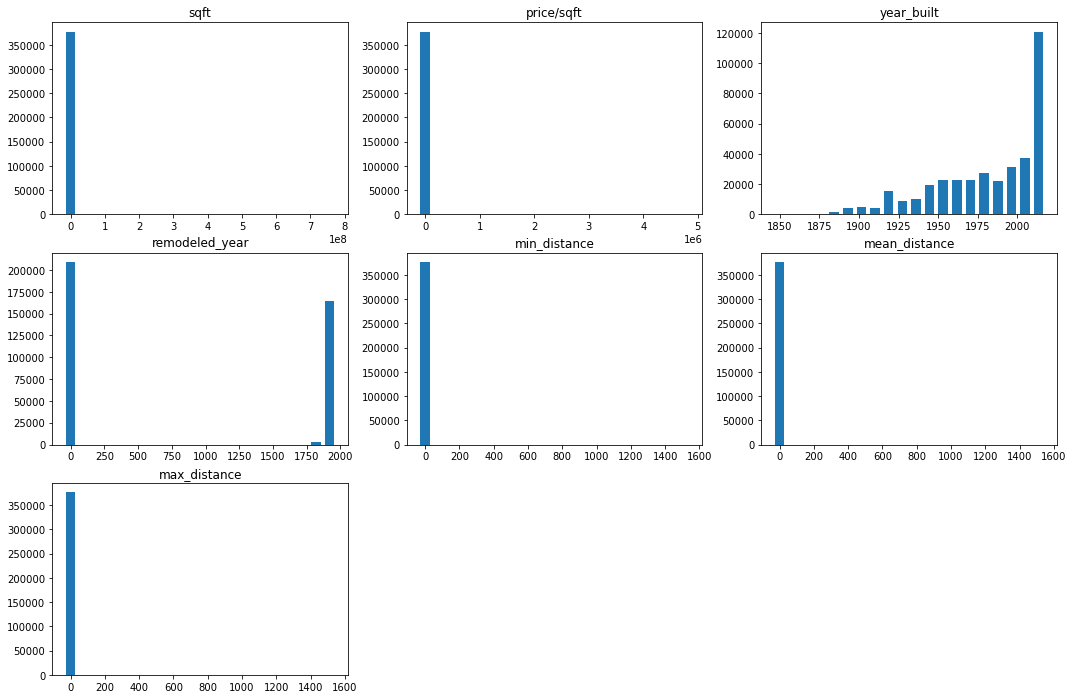

In [315]:
visualize_distributions(df_quantity_variable)

Данные имеют выбросы. Столбец remodeled_year из-за большого количества нулевых значений переведем в качественную переменную (бинарную) с значениями: была реконструкция или нет. Все остальные выбросы отсеим с помощью межквартильных интервалов.

In [316]:
df_quantity_variable = df_quantity_variable.drop('remodeled_year', axis = 1)

In [320]:
for i in df_quantity_variable.columns:
    IQR = df_quantity_variable[i].quantile(0.75) - df_quantity_variable[i].quantile(0.25)
    var_reload = df_quantity_variable[i].median()
    for j in tqdm(range(len(df_quantity_variable))):
        if df_quantity_variable.loc[j, i] < df_quantity_variable[i].quantile(0.25) - 1.5 * IQR or \
        df_quantity_variable.loc[j, i] > df_quantity_variable[i].quantile(0.75) + 1.5 * IQR:
            df_quantity_variable.loc[j, i] = var_reload        

100%|██████████| 377185/377185 [1:34:46<00:00, 66.33it/s]


In [346]:
#df_quantity_variable.to_csv(DATA_PATH + 'df_quantity_variable_2.csv')
#df_quantity_variable = pd.read_csv(DATA_PATH + 'df_quantity_variable_2.csv')
#df_quantity_variable = df_quantity_variable.drop('Unnamed: 0', axis = 1)

In [324]:
# Для приведения распределения к форме нормального распределения прологарифмируем данные
df_quantity_variable['sqft'] = df_quantity_variable['sqft'].apply(lambda x: np.log(x + 1))
df_quantity_variable['price/sqft'] = df_quantity_variable['price/sqft'].apply(lambda x: np.log(x + 1))
df_quantity_variable['year_built'] = df_quantity_variable['year_built'].apply(lambda x: np.log(x + 1))
df_quantity_variable['min_distance'] = df_quantity_variable['min_distance'].apply(lambda x: np.log(x + 1))
df_quantity_variable['mean_distance'] = df_quantity_variable['mean_distance'].apply(lambda x: np.log(x + 1))
df_quantity_variable['max_distance'] = df_quantity_variable['max_distance'].apply(lambda x: np.log(x + 1))

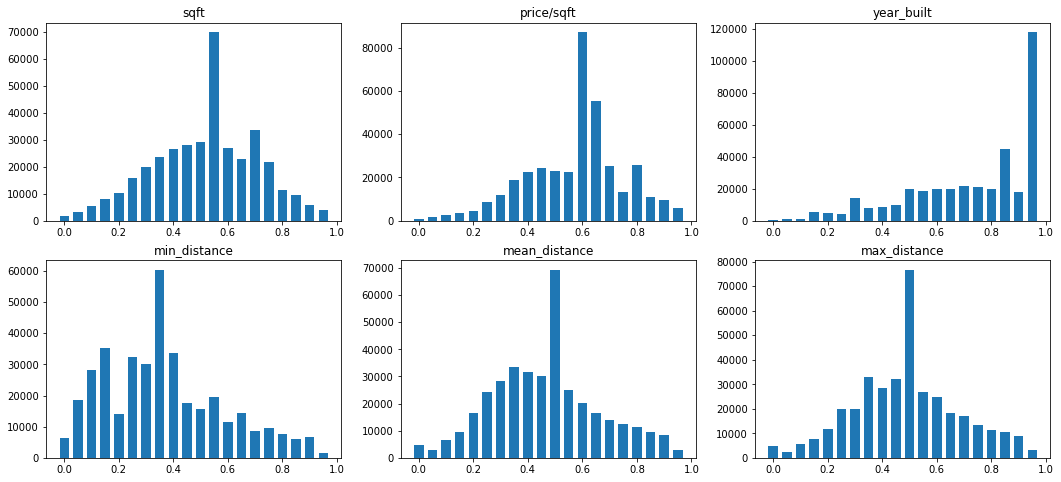

In [349]:
visualize_distributions(df_quantity_variable)

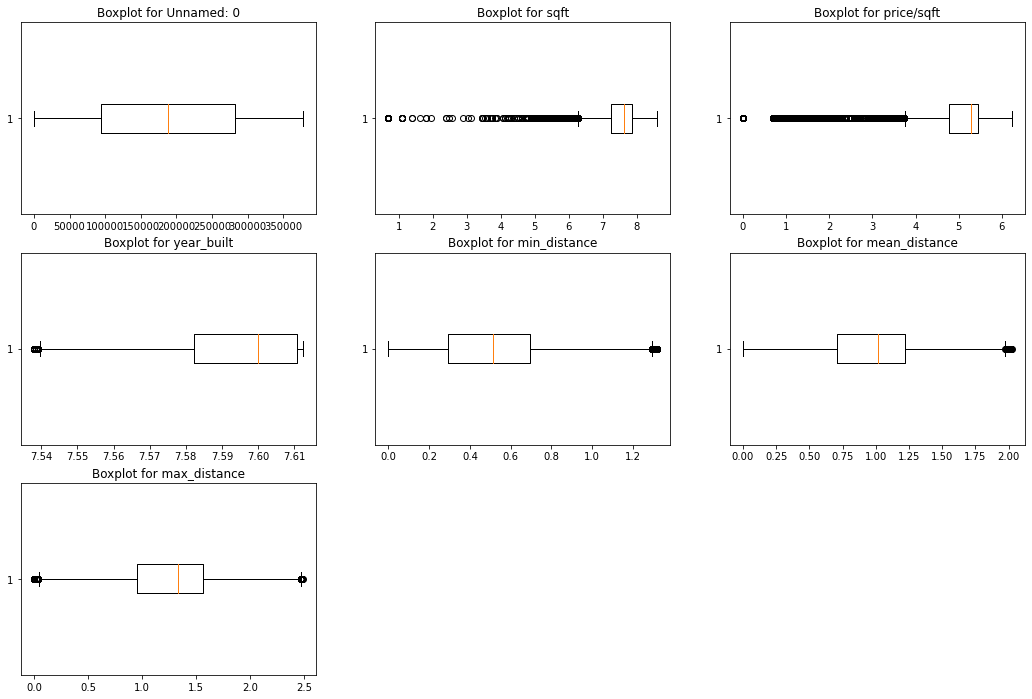

In [326]:
get_boxplot(df_quantity_variable)

Форма распределения случайной величины в столбцах min_distance, mean_distance, max_distance приблизилась к нормальному закону распределения. Данные в столбце sqft и price/sqft проверим еще раз на выбросы. Данные в столбце year_built больше изменять не будем.  

In [327]:
for i in ['sqft', 'price/sqft']:
    IQR = df_quantity_variable[i].quantile(0.75) - df_quantity_variable[i].quantile(0.25)
    var_reload = df_quantity_variable[i].median()
    for j in tqdm(range(len(df_quantity_variable))):
        if df_quantity_variable.loc[j, i] < df_quantity_variable[i].quantile(0.25) - 1.5 * IQR or \
        df_quantity_variable.loc[j, i] > df_quantity_variable[i].quantile(0.75) + 1.5 * IQR:
            df_quantity_variable.loc[j, i] = var_reload 

100%|██████████| 377185/377185 [1:24:05<00:00, 74.76it/s]


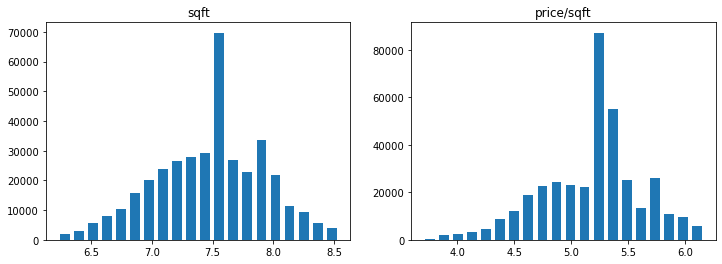

In [328]:
visualize_distributions(df_quantity_variable[['sqft', 'price/sqft']])

In [350]:
df_quantity_variable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sqft           377185 non-null  float64
 1   price/sqft     377185 non-null  float64
 2   year_built     377185 non-null  float64
 3   min_distance   377185 non-null  float64
 4   mean_distance  377185 non-null  float64
 5   max_distance   377185 non-null  float64
dtypes: float64(6)
memory usage: 17.3 MB


In [330]:
df_quantity_variable = pd.DataFrame(MinMaxScaler().fit_transform(df_quantity_variable.values), columns = df_quantity_variable.columns)

In [351]:
df_quantity_variable.shape

(377185, 6)

### Качественные переменные

- Data Frame "city_pop" - содержит зашифрованную информацию о населении в городе
- Series df_work['mls_id'] - содержит информацию о наличии mls id 
- Data Frame df_status - содержит зашифрованную информацию о статусе состояния продажи
- Data Frame df_bathroom - содержит информацию о количестве ванных комнат в помещении
- Data Frame df_property_type - содержит зашифрованную информацию о типе недвижимости
- Series df_work['Pool'] - содержит информацию о наличии бассейна
- Data Frame df_quan_beds - содержит зашифрованную информацию о количестве комнат
- Series df_work['yes_fireplace'] - содержит информацию о наличии камина
- Data Frame df_rating_school - содержит информацию рейтинге школ, находящихся рядом с недвижимостью
- Series df_school['preschool']  	
- Series df_school['elementary_school'] 	
- Series df_school['middle_school'] 	
- Series df_school['high_school'] 
- Series df_type_school['private']
- Series df_home_info['heating'] 
- Series df_home_info['cooling'] 
- Series df_home_info['parking']
- Series df_home_info['remodeled_year'] - была реконструкция или нет;

In [332]:
df_quality_variable = pd.DataFrame(columns = ['city_pop_1', 'city_pop_2', 'city_pop_3', 'city_pop_4','mls_id'\
                                             'status_active', 'status_auction', 'status_for_sale', 'status_foreclosure',\
                                             'status_other', 'status_pending', 'status_show', '1_bath', '2_bath',\
                                             '3_bath', '4_bath', '0.5_bath', '0.25_bath',\
                                             'type_condo', 'type_coop', 'type_detached', 'type_land', 'type_multi_fam', \
                                             'type_other', 'type_single_fam', 'townhouse', 'traditional', \
                                             'pool', '1_beds', '2_beds', '3_beds', '4_beds', '5_beds',\
                                             'fireplace', 'sc_rating_1', 'sc_rating_2', 'sc_rating_3', 'sc_rating_4',\
                                             'sc_rating_5', 'sc_rating_6', 'sc_rating_7', 'sc_rating_8', 'sc_rating_9', 'sc_rating_10',\
                                             'preschool', 'elementary_school', 'middle_school', 'high_school', \
                                             'private_school', 'heating', 'cooling', 'parking', 'remodeled_year'])

In [333]:
df_quality_variable[['city_pop_1', 'city_pop_2', 'city_pop_3', 'city_pop_4']] = city_pop.copy()
df_quality_variable['mls_id'] = df_work['mls_id'].copy()
df_quality_variable[['status_active', 'status_auction', 'status_for_sale', 'status_foreclosure', \
                     'status_other', 'status_pending', 'status_show']] = df_status.copy()
df_quality_variable[['1_bath', '2_bath', '3_bath', '4_bath', '0.5_bath', '0.25_bath']] = df_bathroom.copy()
df_quality_variable[['type_condo', 'type_coop', 'type_detached', 'type_land', 'type_multi_fam', \
                     'type_other', 'type_single_fam', 'townhouse', 'traditional']] = df_property_type.copy()
df_quality_variable['pool'] = df_work['Pool'].copy()
df_quality_variable[['1_beds', '2_beds', '3_beds', '4_beds', '5_beds']] = df_quan_beds.copy()
df_quality_variable['fireplace'] = df_work['yes_fireplace'].copy()
df_quality_variable[['sc_rating_1', 'sc_rating_2', 'sc_rating_3', 'sc_rating_4', 'sc_rating_5', 'sc_rating_6',\
                     'sc_rating_7', 'sc_rating_8', 'sc_rating_9', 'sc_rating_10']] = df_rating_school.copy()
df_quality_variable[['preschool', 'elementary_school', 'middle_school', 'high_school']] = df_school[['preschool', 'elementary_school', 'middle_school','high_school']].copy()
df_quality_variable['private_school'] = df_type_school['private'].copy()
df_quality_variable[['heating', 'cooling', 'parking', 'remodeled_year']] = df_home_info[['heating', 'cooling', 'parking', 'remodeled_year']].copy()

In [334]:
df_quality_variable = df_quality_variable.fillna(0)
df_quality_variable['remodeled_year'] = df_quality_variable['remodeled_year'].apply(lambda x : 1 if x != 0 else 0)

In [335]:
df_quality_variable.head(5)

,city_pop_1,city_pop_2,city_pop_3,city_pop_4,mls_idstatus_active,status_auction,status_for_sale,status_foreclosure,status_other,status_pending,status_show,1_bath,2_bath,3_bath,4_bath,0.5_bath,0.25_bath,type_condo,type_coop,type_detached,type_land,type_multi_fam,type_other,type_single_fam,townhouse,...,3_beds,4_beds,5_beds,fireplace,sc_rating_1,sc_rating_2,sc_rating_3,sc_rating_4,sc_rating_5,sc_rating_6,sc_rating_7,sc_rating_8,sc_rating_9,sc_rating_10,preschool,elementary_school,middle_school,high_school,private_school,heating,cooling,parking,remodeled_year,mls_id,status_active
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0.0,0,0,0,0,0,0,1,0,...,1,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1,1.0,0.0,0.0,0,1.0,1
1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0,1.0,0
2,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1.0,0.0,1.0,1,1.0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0,0,0,0,0,0,1,0,...,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,0.0,1.0,1,1.0,0
4,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0.0,0.0,0.0,0,1.0,0


In [336]:
df_quality_variable = df_quality_variable.astype(int)

In [337]:
df_quality_variable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 54 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   city_pop_1           377185 non-null  int64
 1   city_pop_2           377185 non-null  int64
 2   city_pop_3           377185 non-null  int64
 3   city_pop_4           377185 non-null  int64
 4   mls_idstatus_active  377185 non-null  int64
 5   status_auction       377185 non-null  int64
 6   status_for_sale      377185 non-null  int64
 7   status_foreclosure   377185 non-null  int64
 8   status_other         377185 non-null  int64
 9   status_pending       377185 non-null  int64
 10  status_show          377185 non-null  int64
 11  1_bath               377185 non-null  int64
 12  2_bath               377185 non-null  int64
 13  3_bath               377185 non-null  int64
 14  4_bath               377185 non-null  int64
 15  0.5_bath             377185 non-null  int64
 16  0.

### Данные для обучения

In [352]:
df_learn = df_quantity_variable.copy()

In [353]:
df_learn = df_learn.join(df_quality_variable)

In [354]:
df_learn = df_learn.join(df_work['target'])

In [4]:
#df_learn.to_csv(DATA_PATH + 'df_learn.csv')
#df_learn = df_learn.drop('target', axis = 1)
df_learn = pd.read_csv(DATA_PATH + 'df_learn.csv')
df_learn = df_learn.drop('Unnamed: 0', axis = 1)

In [5]:
df_learn.shape

(377185, 61)

In [6]:
df_learn

,sqft,price/sqft,year_built,min_distance,mean_distance,max_distance,city_pop_1,city_pop_2,city_pop_3,city_pop_4,...,middle_school,high_school,private_school,heating,cooling,parking,remodeled_year,mls_id,status_active,target
0,0.730379,0.493050,0.980046,0.991848,0.928467,0.537244,0,0,1,0,...,1,1,1,1,0,0,0,1,1,418000.0
1,0.558129,0.532979,0.980046,0.529257,0.417581,0.392192,1,0,0,0,...,1,1,0,0,0,0,0,1,0,310000.0
2,0.745037,0.615297,0.588336,0.594276,0.536635,0.518825,0,0,0,1,...,1,1,0,1,0,1,1,1,0,2895000.0
3,0.574896,0.875213,0.893236,0.072255,0.277441,0.288880,0,0,0,1,...,1,1,0,1,0,1,1,1,0,2395000.0
4,0.998639,0.663992,0.980046,0.388772,0.803730,0.780786,0,1,0,0,...,1,1,0,0,0,0,0,1,0,514166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,0.871262,0.803867,0.785617,0.562463,0.502488,0.537244,0,1,0,0,...,1,1,0,0,0,1,1,1,0,1249000.0
377181,0.569739,0.836334,0.332354,0.255080,0.809857,0.537244,0,0,0,1,...,1,1,0,0,0,0,0,1,0,674999.0
377182,0.331302,0.960457,0.512741,0.297207,0.233964,0.220580,0,0,1,0,...,1,0,0,0,0,0,1,0,0,528000.0
377183,0.714898,0.674857,0.980046,0.307383,0.397335,0.428471,0,0,0,1,...,1,1,0,0,0,0,0,0,0,34500.0


### Split Data

In [9]:
y = df_learn['target'].values 
X = df_learn.drop('target', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model

### Model 1: CatBoostRegressor

In [359]:
model = CatBoostRegressor(iterations = 5000,
                          loss_function='MAPE'
                         )
model.fit(X_train, y_train)


0:	learn: 0.7875070	total: 204ms	remaining: 17m 2s
1:	learn: 0.7804927	total: 262ms	remaining: 10m 53s
2:	learn: 0.7739649	total: 316ms	remaining: 8m 47s
3:	learn: 0.7673099	total: 374ms	remaining: 7m 46s
4:	learn: 0.7615144	total: 430ms	remaining: 7m 9s
5:	learn: 0.7570732	total: 487ms	remaining: 6m 45s
6:	learn: 0.7531309	total: 540ms	remaining: 6m 25s
7:	learn: 0.7495238	total: 591ms	remaining: 6m 9s
8:	learn: 0.7468664	total: 648ms	remaining: 5m 59s
9:	learn: 0.7445382	total: 707ms	remaining: 5m 52s
10:	learn: 0.7420368	total: 762ms	remaining: 5m 45s
11:	learn: 0.7391499	total: 813ms	remaining: 5m 37s
12:	learn: 0.7375275	total: 865ms	remaining: 5m 32s
13:	learn: 0.7362106	total: 925ms	remaining: 5m 29s
14:	learn: 0.7351364	total: 989ms	remaining: 5m 28s
15:	learn: 0.7341307	total: 1.04s	remaining: 5m 23s
16:	learn: 0.7327793	total: 1.1s	remaining: 5m 21s
17:	learn: 0.7319956	total: 1.15s	remaining: 5m 18s
18:	learn: 0.7319354	total: 1.21s	remaining: 5m 17s
19:	learn: 0.7312289	tot

160:	learn: 0.7102791	total: 8.67s	remaining: 4m 20s
161:	learn: 0.7102790	total: 8.72s	remaining: 4m 20s
162:	learn: 0.7102660	total: 8.77s	remaining: 4m 20s
163:	learn: 0.7102657	total: 8.82s	remaining: 4m 20s
164:	learn: 0.7102656	total: 8.87s	remaining: 4m 19s
165:	learn: 0.7102656	total: 8.92s	remaining: 4m 19s
166:	learn: 0.7102655	total: 8.97s	remaining: 4m 19s
167:	learn: 0.7101850	total: 9.03s	remaining: 4m 19s
168:	learn: 0.7101849	total: 9.08s	remaining: 4m 19s
169:	learn: 0.7101848	total: 9.13s	remaining: 4m 19s
170:	learn: 0.7101845	total: 9.18s	remaining: 4m 19s
171:	learn: 0.7087610	total: 9.23s	remaining: 4m 19s
172:	learn: 0.7087389	total: 9.29s	remaining: 4m 19s
173:	learn: 0.7087389	total: 9.34s	remaining: 4m 18s
174:	learn: 0.7087033	total: 9.39s	remaining: 4m 18s
175:	learn: 0.7087033	total: 9.44s	remaining: 4m 18s
176:	learn: 0.7087020	total: 9.49s	remaining: 4m 18s
177:	learn: 0.7087019	total: 9.54s	remaining: 4m 18s
178:	learn: 0.7086594	total: 9.6s	remaining: 4

317:	learn: 0.7064043	total: 16.8s	remaining: 4m 6s
318:	learn: 0.7064043	total: 16.8s	remaining: 4m 6s
319:	learn: 0.7064043	total: 16.9s	remaining: 4m 6s
320:	learn: 0.7064043	total: 16.9s	remaining: 4m 6s
321:	learn: 0.7064043	total: 17s	remaining: 4m 6s
322:	learn: 0.7064045	total: 17s	remaining: 4m 6s
323:	learn: 0.7064039	total: 17.1s	remaining: 4m 6s
324:	learn: 0.7064037	total: 17.1s	remaining: 4m 6s
325:	learn: 0.7064037	total: 17.2s	remaining: 4m 6s
326:	learn: 0.7064037	total: 17.2s	remaining: 4m 6s
327:	learn: 0.7064037	total: 17.3s	remaining: 4m 6s
328:	learn: 0.7064037	total: 17.3s	remaining: 4m 6s
329:	learn: 0.7064037	total: 17.4s	remaining: 4m 6s
330:	learn: 0.7064037	total: 17.4s	remaining: 4m 6s
331:	learn: 0.7064038	total: 17.5s	remaining: 4m 5s
332:	learn: 0.7064038	total: 17.5s	remaining: 4m 5s
333:	learn: 0.7064037	total: 17.6s	remaining: 4m 5s
334:	learn: 0.7064037	total: 17.6s	remaining: 4m 5s
335:	learn: 0.7064037	total: 17.7s	remaining: 4m 5s
336:	learn: 0.70

478:	learn: 0.7062354	total: 25s	remaining: 3m 56s
479:	learn: 0.7062354	total: 25.1s	remaining: 3m 56s
480:	learn: 0.7062354	total: 25.1s	remaining: 3m 56s
481:	learn: 0.7062354	total: 25.2s	remaining: 3m 56s
482:	learn: 0.7062354	total: 25.2s	remaining: 3m 56s
483:	learn: 0.7062354	total: 25.3s	remaining: 3m 56s
484:	learn: 0.7062354	total: 25.3s	remaining: 3m 55s
485:	learn: 0.7062354	total: 25.4s	remaining: 3m 55s
486:	learn: 0.7062354	total: 25.4s	remaining: 3m 55s
487:	learn: 0.7062353	total: 25.5s	remaining: 3m 55s
488:	learn: 0.7062352	total: 25.6s	remaining: 3m 55s
489:	learn: 0.7062352	total: 25.6s	remaining: 3m 55s
490:	learn: 0.7062352	total: 25.7s	remaining: 3m 55s
491:	learn: 0.7062352	total: 25.7s	remaining: 3m 55s
492:	learn: 0.7062352	total: 25.8s	remaining: 3m 55s
493:	learn: 0.7062352	total: 25.8s	remaining: 3m 55s
494:	learn: 0.7062352	total: 25.9s	remaining: 3m 55s
495:	learn: 0.7062352	total: 25.9s	remaining: 3m 55s
496:	learn: 0.7062351	total: 26s	remaining: 3m 5

635:	learn: 0.7062345	total: 33.7s	remaining: 3m 51s
636:	learn: 0.7062345	total: 33.7s	remaining: 3m 50s
637:	learn: 0.7062345	total: 33.8s	remaining: 3m 50s
638:	learn: 0.7062345	total: 33.8s	remaining: 3m 50s
639:	learn: 0.7062345	total: 33.9s	remaining: 3m 50s
640:	learn: 0.7062345	total: 33.9s	remaining: 3m 50s
641:	learn: 0.7062345	total: 34s	remaining: 3m 50s
642:	learn: 0.7062345	total: 34s	remaining: 3m 50s
643:	learn: 0.7062345	total: 34.1s	remaining: 3m 50s
644:	learn: 0.7062345	total: 34.1s	remaining: 3m 50s
645:	learn: 0.7062345	total: 34.2s	remaining: 3m 50s
646:	learn: 0.7062345	total: 34.2s	remaining: 3m 50s
647:	learn: 0.7062345	total: 34.3s	remaining: 3m 50s
648:	learn: 0.7062345	total: 34.3s	remaining: 3m 50s
649:	learn: 0.7062345	total: 34.4s	remaining: 3m 50s
650:	learn: 0.7062345	total: 34.4s	remaining: 3m 50s
651:	learn: 0.7062345	total: 34.5s	remaining: 3m 49s
652:	learn: 0.7062345	total: 34.5s	remaining: 3m 49s
653:	learn: 0.7062345	total: 34.6s	remaining: 3m 4

791:	learn: 0.7062344	total: 41.8s	remaining: 3m 42s
792:	learn: 0.7062344	total: 41.9s	remaining: 3m 42s
793:	learn: 0.7062344	total: 41.9s	remaining: 3m 41s
794:	learn: 0.7062344	total: 42s	remaining: 3m 41s
795:	learn: 0.7062344	total: 42s	remaining: 3m 41s
796:	learn: 0.7062344	total: 42.1s	remaining: 3m 41s
797:	learn: 0.7062344	total: 42.1s	remaining: 3m 41s
798:	learn: 0.7062344	total: 42.2s	remaining: 3m 41s
799:	learn: 0.7062344	total: 42.2s	remaining: 3m 41s
800:	learn: 0.7062344	total: 42.3s	remaining: 3m 41s
801:	learn: 0.7062344	total: 42.3s	remaining: 3m 41s
802:	learn: 0.7062344	total: 42.4s	remaining: 3m 41s
803:	learn: 0.7062344	total: 42.4s	remaining: 3m 41s
804:	learn: 0.7062344	total: 42.5s	remaining: 3m 41s
805:	learn: 0.7062344	total: 42.5s	remaining: 3m 41s
806:	learn: 0.7062344	total: 42.6s	remaining: 3m 41s
807:	learn: 0.7062344	total: 42.6s	remaining: 3m 41s
808:	learn: 0.7062344	total: 42.7s	remaining: 3m 41s
809:	learn: 0.7062344	total: 42.7s	remaining: 3m 4

947:	learn: 0.7062344	total: 50.1s	remaining: 3m 33s
948:	learn: 0.7062344	total: 50.1s	remaining: 3m 33s
949:	learn: 0.7062344	total: 50.2s	remaining: 3m 33s
950:	learn: 0.7062344	total: 50.2s	remaining: 3m 33s
951:	learn: 0.7062344	total: 50.3s	remaining: 3m 33s
952:	learn: 0.7062344	total: 50.3s	remaining: 3m 33s
953:	learn: 0.7062344	total: 50.4s	remaining: 3m 33s
954:	learn: 0.7062344	total: 50.5s	remaining: 3m 33s
955:	learn: 0.7062344	total: 50.5s	remaining: 3m 33s
956:	learn: 0.7062344	total: 50.6s	remaining: 3m 33s
957:	learn: 0.7062344	total: 50.6s	remaining: 3m 33s
958:	learn: 0.7062344	total: 50.7s	remaining: 3m 33s
959:	learn: 0.7062344	total: 50.7s	remaining: 3m 33s
960:	learn: 0.7062344	total: 50.8s	remaining: 3m 33s
961:	learn: 0.7062344	total: 50.8s	remaining: 3m 33s
962:	learn: 0.7062344	total: 50.9s	remaining: 3m 33s
963:	learn: 0.7062344	total: 50.9s	remaining: 3m 33s
964:	learn: 0.7062344	total: 51s	remaining: 3m 33s
965:	learn: 0.7062344	total: 51s	remaining: 3m 3

1104:	learn: 0.7062344	total: 58.4s	remaining: 3m 25s
1105:	learn: 0.7062344	total: 58.4s	remaining: 3m 25s
1106:	learn: 0.7062344	total: 58.5s	remaining: 3m 25s
1107:	learn: 0.7062344	total: 58.5s	remaining: 3m 25s
1108:	learn: 0.7062344	total: 58.6s	remaining: 3m 25s
1109:	learn: 0.7062344	total: 58.6s	remaining: 3m 25s
1110:	learn: 0.7062344	total: 58.7s	remaining: 3m 25s
1111:	learn: 0.7062344	total: 58.7s	remaining: 3m 25s
1112:	learn: 0.7062344	total: 58.8s	remaining: 3m 25s
1113:	learn: 0.7062344	total: 58.9s	remaining: 3m 25s
1114:	learn: 0.7062344	total: 58.9s	remaining: 3m 25s
1115:	learn: 0.7062344	total: 59s	remaining: 3m 25s
1116:	learn: 0.7062344	total: 59s	remaining: 3m 25s
1117:	learn: 0.7062344	total: 59.1s	remaining: 3m 25s
1118:	learn: 0.7062344	total: 59.2s	remaining: 3m 25s
1119:	learn: 0.7062344	total: 59.2s	remaining: 3m 25s
1120:	learn: 0.7062344	total: 59.3s	remaining: 3m 25s
1121:	learn: 0.7062344	total: 59.3s	remaining: 3m 25s
1122:	learn: 0.7062344	total: 59

1260:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1261:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1262:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1263:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1264:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1265:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1266:	learn: 0.7062344	total: 1m 6s	remaining: 3m 17s
1267:	learn: 0.7062344	total: 1m 7s	remaining: 3m 17s
1268:	learn: 0.7062344	total: 1m 7s	remaining: 3m 17s
1269:	learn: 0.7062344	total: 1m 7s	remaining: 3m 17s
1270:	learn: 0.7062344	total: 1m 7s	remaining: 3m 17s
1271:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1272:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1273:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1274:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1275:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1276:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1277:	learn: 0.7062344	total: 1m 7s	remaining: 3m 16s
1278:	learn: 0.7062344	total

1412:	learn: 0.7062344	total: 1m 14s	remaining: 3m 9s
1413:	learn: 0.7062344	total: 1m 14s	remaining: 3m 9s
1414:	learn: 0.7062344	total: 1m 14s	remaining: 3m 9s
1415:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1416:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1417:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1418:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1419:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1420:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1421:	learn: 0.7062344	total: 1m 14s	remaining: 3m 8s
1422:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1423:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1424:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1425:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1426:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1427:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1428:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1429:	learn: 0.7062344	total: 1m 15s	remaining: 3m 8s
1430:	learn: 0.7062344	total

1564:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1565:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1566:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1567:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1568:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1569:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1570:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1571:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1572:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1573:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1574:	learn: 0.7062344	total: 1m 22s	remaining: 3m
1575:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1576:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1577:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1578:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1579:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1580:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1581:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1582:	learn: 0.7062344	total: 1m 23s	remaining: 3m
1583:	learn: 0.7062344	total: 1

1716:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1717:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1718:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1719:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1720:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1721:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1722:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1723:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1724:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1725:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1726:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1727:	learn: 0.7062344	total: 1m 30s	remaining: 2m 52s
1728:	learn: 0.7062344	total: 1m 31s	remaining: 2m 52s
1729:	learn: 0.7062344	total: 1m 31s	remaining: 2m 52s
1730:	learn: 0.7062344	total: 1m 31s	remaining: 2m 52s
1731:	learn: 0.7062344	total: 1m 31s	remaining: 2m 52s
1732:	learn: 0.7062344	total: 1m 31s	remaining: 2m 51s
1733:	learn: 0.7062344	total: 1m 31s	remaining: 2m 51s
1734:	lear

1868:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1869:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1870:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1871:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1872:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1873:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1874:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1875:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1876:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1877:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1878:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1879:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1880:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1881:	learn: 0.7062344	total: 1m 38s	remaining: 2m 44s
1882:	learn: 0.7062344	total: 1m 39s	remaining: 2m 43s
1883:	learn: 0.7062344	total: 1m 39s	remaining: 2m 43s
1884:	learn: 0.7062344	total: 1m 39s	remaining: 2m 43s
1885:	learn: 0.7062344	total: 1m 39s	remaining: 2m 43s
1886:	lear

2020:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2021:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2022:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2023:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2024:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2025:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2026:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2027:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2028:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2029:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2030:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2031:	learn: 0.7062344	total: 1m 46s	remaining: 2m 36s
2032:	learn: 0.7062344	total: 1m 46s	remaining: 2m 35s
2033:	learn: 0.7062344	total: 1m 46s	remaining: 2m 35s
2034:	learn: 0.7062344	total: 1m 46s	remaining: 2m 35s
2035:	learn: 0.7062344	total: 1m 47s	remaining: 2m 35s
2036:	learn: 0.7062344	total: 1m 47s	remaining: 2m 35s
2037:	learn: 0.7062344	total: 1m 47s	remaining: 2m 35s
2038:	lear

2172:	learn: 0.7062344	total: 1m 54s	remaining: 2m 29s
2173:	learn: 0.7062344	total: 1m 54s	remaining: 2m 29s
2174:	learn: 0.7062344	total: 1m 54s	remaining: 2m 29s
2175:	learn: 0.7062344	total: 1m 54s	remaining: 2m 29s
2176:	learn: 0.7062344	total: 1m 55s	remaining: 2m 29s
2177:	learn: 0.7062344	total: 1m 55s	remaining: 2m 29s
2178:	learn: 0.7062344	total: 1m 55s	remaining: 2m 29s
2179:	learn: 0.7062344	total: 1m 55s	remaining: 2m 29s
2180:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2181:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2182:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2183:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2184:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2185:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2186:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2187:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2188:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2189:	learn: 0.7062344	total: 1m 55s	remaining: 2m 28s
2190:	lear

2324:	learn: 0.7062344	total: 2m 3s	remaining: 2m 22s
2325:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2326:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2327:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2328:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2329:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2330:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2331:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2332:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2333:	learn: 0.7062344	total: 2m 3s	remaining: 2m 21s
2334:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2335:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2336:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2337:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2338:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2339:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2340:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2341:	learn: 0.7062344	total: 2m 4s	remaining: 2m 21s
2342:	learn: 0.7062344	total

2476:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2477:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2478:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2479:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2480:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2481:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2482:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2483:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2484:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2485:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2486:	learn: 0.7062344	total: 2m 12s	remaining: 2m 14s
2487:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2488:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2489:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2490:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2491:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2492:	learn: 0.7062344	total: 2m 12s	remaining: 2m 13s
2493:	learn: 0.7062344	total: 2m 13s	remaining: 2m 13s
2494:	lear

2628:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2629:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2630:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2631:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2632:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2633:	learn: 0.7062344	total: 2m 20s	remaining: 2m 6s
2634:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2635:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2636:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2637:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2638:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2639:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2640:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2641:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2642:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2643:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2644:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2645:	learn: 0.7062344	total: 2m 21s	remaining: 2m 6s
2646:	learn: 0.7062344	total

2784:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2785:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2786:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2787:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2788:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2789:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2790:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2791:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2792:	learn: 0.7062344	total: 2m 29s	remaining: 1m 58s
2793:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2794:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2795:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2796:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2797:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2798:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2799:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2800:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2801:	learn: 0.7062344	total: 2m 30s	remaining: 1m 58s
2802:	lear

2936:	learn: 0.7062344	total: 2m 38s	remaining: 1m 51s
2937:	learn: 0.7062344	total: 2m 38s	remaining: 1m 51s
2938:	learn: 0.7062344	total: 2m 38s	remaining: 1m 51s
2939:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2940:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2941:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2942:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2943:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2944:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2945:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2946:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2947:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2948:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2949:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2950:	learn: 0.7062344	total: 2m 38s	remaining: 1m 50s
2951:	learn: 0.7062344	total: 2m 39s	remaining: 1m 50s
2952:	learn: 0.7062344	total: 2m 39s	remaining: 1m 50s
2953:	learn: 0.7062344	total: 2m 39s	remaining: 1m 50s
2954:	lear

3088:	learn: 0.7062344	total: 2m 46s	remaining: 1m 43s
3089:	learn: 0.7062344	total: 2m 46s	remaining: 1m 43s
3090:	learn: 0.7062344	total: 2m 47s	remaining: 1m 43s
3091:	learn: 0.7062344	total: 2m 47s	remaining: 1m 43s
3092:	learn: 0.7062344	total: 2m 47s	remaining: 1m 43s
3093:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3094:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3095:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3096:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3097:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3098:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3099:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3100:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3101:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3102:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3103:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3104:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3105:	learn: 0.7062344	total: 2m 47s	remaining: 1m 42s
3106:	lear

3240:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3241:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3242:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3243:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3244:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3245:	learn: 0.7062344	total: 2m 55s	remaining: 1m 35s
3246:	learn: 0.7062344	total: 2m 56s	remaining: 1m 35s
3247:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3248:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3249:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3250:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3251:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3252:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3253:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3254:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3255:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3256:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3257:	learn: 0.7062344	total: 2m 56s	remaining: 1m 34s
3258:	lear

3392:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3393:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3394:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3395:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3396:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3397:	learn: 0.7062344	total: 3m 4s	remaining: 1m 27s
3398:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3399:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3400:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3401:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3402:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3403:	learn: 0.7062344	total: 3m 4s	remaining: 1m 26s
3404:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3405:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3406:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3407:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3408:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3409:	learn: 0.7062344	total: 3m 5s	remaining: 1m 26s
3410:	learn: 0.7062344	total

3544:	learn: 0.7062344	total: 3m 13s	remaining: 1m 19s
3545:	learn: 0.7062344	total: 3m 13s	remaining: 1m 19s
3546:	learn: 0.7062344	total: 3m 13s	remaining: 1m 19s
3547:	learn: 0.7062344	total: 3m 13s	remaining: 1m 19s
3548:	learn: 0.7062344	total: 3m 13s	remaining: 1m 19s
3549:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3550:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3551:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3552:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3553:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3554:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3555:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3556:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3557:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3558:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3559:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3560:	learn: 0.7062344	total: 3m 13s	remaining: 1m 18s
3561:	learn: 0.7062344	total: 3m 14s	remaining: 1m 18s
3562:	lear

3696:	learn: 0.7062344	total: 3m 21s	remaining: 1m 11s
3697:	learn: 0.7062344	total: 3m 21s	remaining: 1m 11s
3698:	learn: 0.7062344	total: 3m 21s	remaining: 1m 10s
3699:	learn: 0.7062344	total: 3m 21s	remaining: 1m 10s
3700:	learn: 0.7062344	total: 3m 21s	remaining: 1m 10s
3701:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3702:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3703:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3704:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3705:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3706:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3707:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3708:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3709:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3710:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3711:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3712:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3713:	learn: 0.7062344	total: 3m 22s	remaining: 1m 10s
3714:	lear

3848:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3849:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3850:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3851:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3852:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3853:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3854:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3855:	learn: 0.7062344	total: 3m 30s	remaining: 1m 2s
3856:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3857:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3858:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3859:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3860:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3861:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3862:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3863:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3864:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3865:	learn: 0.7062344	total: 3m 31s	remaining: 1m 2s
3866:	learn: 0.7062344	total

4004:	learn: 0.7062344	total: 3m 39s	remaining: 54.6s
4005:	learn: 0.7062344	total: 3m 39s	remaining: 54.5s
4006:	learn: 0.7062344	total: 3m 39s	remaining: 54.5s
4007:	learn: 0.7062344	total: 3m 39s	remaining: 54.4s
4008:	learn: 0.7062344	total: 3m 39s	remaining: 54.4s
4009:	learn: 0.7062344	total: 3m 39s	remaining: 54.3s
4010:	learn: 0.7062344	total: 3m 40s	remaining: 54.3s
4011:	learn: 0.7062344	total: 3m 40s	remaining: 54.2s
4012:	learn: 0.7062344	total: 3m 40s	remaining: 54.1s
4013:	learn: 0.7062344	total: 3m 40s	remaining: 54.1s
4014:	learn: 0.7062344	total: 3m 40s	remaining: 54s
4015:	learn: 0.7062344	total: 3m 40s	remaining: 54s
4016:	learn: 0.7062344	total: 3m 40s	remaining: 53.9s
4017:	learn: 0.7062344	total: 3m 40s	remaining: 53.9s
4018:	learn: 0.7062344	total: 3m 40s	remaining: 53.8s
4019:	learn: 0.7062344	total: 3m 40s	remaining: 53.8s
4020:	learn: 0.7062344	total: 3m 40s	remaining: 53.7s
4021:	learn: 0.7062344	total: 3m 40s	remaining: 53.7s
4022:	learn: 0.7062344	total: 3m

4160:	learn: 0.7062344	total: 3m 48s	remaining: 46.1s
4161:	learn: 0.7062344	total: 3m 48s	remaining: 46s
4162:	learn: 0.7062344	total: 3m 48s	remaining: 46s
4163:	learn: 0.7062344	total: 3m 48s	remaining: 45.9s
4164:	learn: 0.7062344	total: 3m 48s	remaining: 45.9s
4165:	learn: 0.7062344	total: 3m 48s	remaining: 45.8s
4166:	learn: 0.7062344	total: 3m 48s	remaining: 45.8s
4167:	learn: 0.7062344	total: 3m 49s	remaining: 45.7s
4168:	learn: 0.7062344	total: 3m 49s	remaining: 45.7s
4169:	learn: 0.7062344	total: 3m 49s	remaining: 45.6s
4170:	learn: 0.7062344	total: 3m 49s	remaining: 45.6s
4171:	learn: 0.7062344	total: 3m 49s	remaining: 45.5s
4172:	learn: 0.7062344	total: 3m 49s	remaining: 45.4s
4173:	learn: 0.7062344	total: 3m 49s	remaining: 45.4s
4174:	learn: 0.7062344	total: 3m 49s	remaining: 45.3s
4175:	learn: 0.7062344	total: 3m 49s	remaining: 45.3s
4176:	learn: 0.7062344	total: 3m 49s	remaining: 45.2s
4177:	learn: 0.7062344	total: 3m 49s	remaining: 45.2s
4178:	learn: 0.7062344	total: 3m

4316:	learn: 0.7062344	total: 3m 57s	remaining: 37.6s
4317:	learn: 0.7062344	total: 3m 57s	remaining: 37.5s
4318:	learn: 0.7062344	total: 3m 57s	remaining: 37.5s
4319:	learn: 0.7062344	total: 3m 57s	remaining: 37.4s
4320:	learn: 0.7062344	total: 3m 57s	remaining: 37.4s
4321:	learn: 0.7062344	total: 3m 57s	remaining: 37.3s
4322:	learn: 0.7062344	total: 3m 58s	remaining: 37.3s
4323:	learn: 0.7062344	total: 3m 58s	remaining: 37.2s
4324:	learn: 0.7062344	total: 3m 58s	remaining: 37.2s
4325:	learn: 0.7062344	total: 3m 58s	remaining: 37.1s
4326:	learn: 0.7062344	total: 3m 58s	remaining: 37.1s
4327:	learn: 0.7062344	total: 3m 58s	remaining: 37s
4328:	learn: 0.7062344	total: 3m 58s	remaining: 36.9s
4329:	learn: 0.7062344	total: 3m 58s	remaining: 36.9s
4330:	learn: 0.7062344	total: 3m 58s	remaining: 36.8s
4331:	learn: 0.7062344	total: 3m 58s	remaining: 36.8s
4332:	learn: 0.7062344	total: 3m 58s	remaining: 36.7s
4333:	learn: 0.7062344	total: 3m 58s	remaining: 36.7s
4334:	learn: 0.7062344	total: 

4472:	learn: 0.7062344	total: 4m 6s	remaining: 29.1s
4473:	learn: 0.7062344	total: 4m 6s	remaining: 29s
4474:	learn: 0.7062344	total: 4m 6s	remaining: 29s
4475:	learn: 0.7062344	total: 4m 6s	remaining: 28.9s
4476:	learn: 0.7062344	total: 4m 7s	remaining: 28.9s
4477:	learn: 0.7062344	total: 4m 7s	remaining: 28.8s
4478:	learn: 0.7062344	total: 4m 7s	remaining: 28.7s
4479:	learn: 0.7062344	total: 4m 7s	remaining: 28.7s
4480:	learn: 0.7062344	total: 4m 7s	remaining: 28.6s
4481:	learn: 0.7062344	total: 4m 7s	remaining: 28.6s
4482:	learn: 0.7062344	total: 4m 7s	remaining: 28.5s
4483:	learn: 0.7062344	total: 4m 7s	remaining: 28.5s
4484:	learn: 0.7062344	total: 4m 7s	remaining: 28.4s
4485:	learn: 0.7062344	total: 4m 7s	remaining: 28.4s
4486:	learn: 0.7062344	total: 4m 7s	remaining: 28.3s
4487:	learn: 0.7062344	total: 4m 7s	remaining: 28.3s
4488:	learn: 0.7062344	total: 4m 7s	remaining: 28.2s
4489:	learn: 0.7062344	total: 4m 7s	remaining: 28.1s
4490:	learn: 0.7062344	total: 4m 7s	remaining: 28.

4628:	learn: 0.7062344	total: 4m 15s	remaining: 20.5s
4629:	learn: 0.7062344	total: 4m 15s	remaining: 20.4s
4630:	learn: 0.7062344	total: 4m 15s	remaining: 20.4s
4631:	learn: 0.7062344	total: 4m 15s	remaining: 20.3s
4632:	learn: 0.7062344	total: 4m 15s	remaining: 20.3s
4633:	learn: 0.7062344	total: 4m 15s	remaining: 20.2s
4634:	learn: 0.7062344	total: 4m 15s	remaining: 20.2s
4635:	learn: 0.7062344	total: 4m 16s	remaining: 20.1s
4636:	learn: 0.7062344	total: 4m 16s	remaining: 20s
4637:	learn: 0.7062344	total: 4m 16s	remaining: 20s
4638:	learn: 0.7062344	total: 4m 16s	remaining: 19.9s
4639:	learn: 0.7062344	total: 4m 16s	remaining: 19.9s
4640:	learn: 0.7062344	total: 4m 16s	remaining: 19.8s
4641:	learn: 0.7062344	total: 4m 16s	remaining: 19.8s
4642:	learn: 0.7062344	total: 4m 16s	remaining: 19.7s
4643:	learn: 0.7062344	total: 4m 16s	remaining: 19.7s
4644:	learn: 0.7062344	total: 4m 16s	remaining: 19.6s
4645:	learn: 0.7062344	total: 4m 16s	remaining: 19.5s
4646:	learn: 0.7062344	total: 4m

4784:	learn: 0.7062344	total: 4m 24s	remaining: 11.9s
4785:	learn: 0.7062344	total: 4m 24s	remaining: 11.8s
4786:	learn: 0.7062344	total: 4m 24s	remaining: 11.8s
4787:	learn: 0.7062344	total: 4m 24s	remaining: 11.7s
4788:	learn: 0.7062344	total: 4m 24s	remaining: 11.7s
4789:	learn: 0.7062344	total: 4m 24s	remaining: 11.6s
4790:	learn: 0.7062344	total: 4m 24s	remaining: 11.6s
4791:	learn: 0.7062344	total: 4m 24s	remaining: 11.5s
4792:	learn: 0.7062344	total: 4m 25s	remaining: 11.4s
4793:	learn: 0.7062344	total: 4m 25s	remaining: 11.4s
4794:	learn: 0.7062344	total: 4m 25s	remaining: 11.3s
4795:	learn: 0.7062344	total: 4m 25s	remaining: 11.3s
4796:	learn: 0.7062344	total: 4m 25s	remaining: 11.2s
4797:	learn: 0.7062344	total: 4m 25s	remaining: 11.2s
4798:	learn: 0.7062344	total: 4m 25s	remaining: 11.1s
4799:	learn: 0.7062344	total: 4m 25s	remaining: 11.1s
4800:	learn: 0.7062344	total: 4m 25s	remaining: 11s
4801:	learn: 0.7062344	total: 4m 25s	remaining: 10.9s
4802:	learn: 0.7062344	total: 

4940:	learn: 0.7062344	total: 4m 33s	remaining: 3.27s
4941:	learn: 0.7062344	total: 4m 33s	remaining: 3.21s
4942:	learn: 0.7062344	total: 4m 33s	remaining: 3.16s
4943:	learn: 0.7062344	total: 4m 33s	remaining: 3.1s
4944:	learn: 0.7062344	total: 4m 33s	remaining: 3.05s
4945:	learn: 0.7062344	total: 4m 34s	remaining: 2.99s
4946:	learn: 0.7062344	total: 4m 34s	remaining: 2.94s
4947:	learn: 0.7062344	total: 4m 34s	remaining: 2.88s
4948:	learn: 0.7062344	total: 4m 34s	remaining: 2.83s
4949:	learn: 0.7062344	total: 4m 34s	remaining: 2.77s
4950:	learn: 0.7062344	total: 4m 34s	remaining: 2.71s
4951:	learn: 0.7062344	total: 4m 34s	remaining: 2.66s
4952:	learn: 0.7062344	total: 4m 34s	remaining: 2.6s
4953:	learn: 0.7062344	total: 4m 34s	remaining: 2.55s
4954:	learn: 0.7062344	total: 4m 34s	remaining: 2.49s
4955:	learn: 0.7062344	total: 4m 34s	remaining: 2.44s
4956:	learn: 0.7062344	total: 4m 34s	remaining: 2.38s
4957:	learn: 0.7062344	total: 4m 34s	remaining: 2.33s
4958:	learn: 0.7062344	total: 

In [360]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 70.95%


### Model 2: Tabular NN

In [361]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [362]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               31232     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 162,817
Trainable params: 162,817
Non-trainable params: 0
_________________________________________________________________


In [363]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [364]:
checkpoint = ModelCheckpoint(DATA_PATH + 'best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [365]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

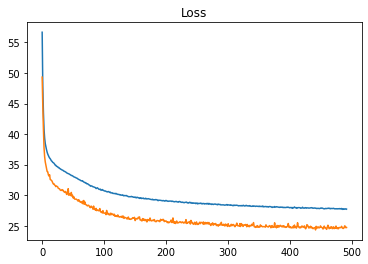

In [366]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [367]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 24.30%


### Стекинг c помощью StackingRegressor

In [10]:
estimators = [
    ('lr', LinearRegression(normalize = True)),
    ('kn', KNeighborsRegressor()),
    ('etr', ExtraTreesRegressor(random_state = RANDOM_SEED)), 
    ('abr', AdaBoostRegressor(random_state = RANDOM_SEED))
             ]

In [11]:
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=LinearRegression())

In [ ]:
stacking_regressor.fit(X_train, y_train)